# Fitting COSMOS-HSC (UDeep) Data with MultiProFit

This notebook plots results from fitting sources from the Hyper-Suprime Cam (HSC) Subaru Strategic Program (SSP, https://hsc-release.mtk.nao.ac.jp/doc/) UltraDeep grizy imaging of the COSMOS field (http://cosmos.astro.caltech.edu/) using MultiProFit (https://github.com/lsst-dm/multiprofit). Specifically, it reads the results of using a Task to fit exposures given an existing catalog with fits from meas_modelfit (https://github.com/lsst/meas_modelfit), which implements a minor variant of the SDSS CModel algorithm. In additional to implementing (a slight variation of) the CModel algorithm, MultiProFit allows for multi-band fitting, as well as fitting of Sersic profiles and non-parametric radial profiles (Gaussian mixtures). Thus, the main results are comparisons of the two codes doing basically the same thing (single-band exponential, de Vaucouleurs, and cmodel linear combination fits), followed by plots highlighting Sersic vs CModel fits, and MultiProFit's multi-band performance.

In [1]:
# Import required packages
from lsst.afw.table import SourceCatalog
from modelling_research.plotting import plotjoint_running_percentiles
from multiprofit.utils import flux_to_mag, mag_to_flux
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns

In [2]:
# Setup for plotting
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

argspj = dict(
    percentiles = [5, 16, 50, 84, 95],
    percentilecolours = [(0.4, 0.6, 0.8), (0.2, 0.3, 0.4), (0., 0., 0.), (0.2, 0.3, 0.4), (0.4, 0.6, 0.8)],
    scatterleft=True,
    scatterright=True,
)

In [3]:
# Read catalogs
cat_i = SourceCatalog.readFits("/project/dtaranu/cosmos/hsc/2019-10-23/mpf_9813_4,4_i_mag.fits")
cat_gri = SourceCatalog.readFits("/project/dtaranu/cosmos/hsc/2019-10-23/mpf_9813_4,4_gri_mag.fits")
cats = {
    "i": cat_i,
    "gri": cat_gri,
}

In [4]:
# Setup models and familiar names for parameters
models = {
    "psf": {
        "mpf": ("multiprofit_psf_HSC-I_", 2),
        "mmf": ("modelfit_DoubleShapeletPsfApprox_", 2),
    },
    "exp": {
        "mpf": ("multiprofit_mg8expgpx_", 1),
        "mmf": ("modelfit_CModel_exp_", 1),
    },
    "dev": {
        "mpf": ("multiprofit_mg8devepx_", 1),
        "mmf": ("modelfit_CModel_dev_", 1),
    },
    "cmodel": {
        "mpf": ("multiprofit_mg8cmodelpx_", 2),
        "mmf": ("modelfit_CModel_", 1),
    },
    "mg8serb": {
        "mpf": ("multiprofit_mg8serbpx_", 1),
    },
    "mg8serm": {
        "mpf": ("multiprofit_mg8sermpx_", 1),
    },
}

names = {
    "mag": {
        "mpf": "HSC-I_mag",
        "mpf-psf": None,
        "mmf": "mag",
        "mmf-psf": None,
    },
    "sigma_x": {
        "mpf": "sigma_x",
        "mmf": "ellipse_xx",
        "mmf-psf": "xx",
    },
    "sigma_y": {
        "mpf": "sigma_y",
        "mmf": "ellipse_yy",
        "mmf-psf": "yy",
    },
    "rho": {
        "mpf": "rho",
        "mmf": "ellipse_xy",
        "mmf-psf": "xy",
    },
    "nser": {
        "mpf": "nser",
    },
    "loglike": {
        "mpf": "loglike",
        "mmf": "like",
    },
    "chisqred": {
        "mpf": "chisqred",
    }
}
names_extra = ["time"]
names_optional = ["nser", "loglike", "chisqred"]
names_base = ["deblend_tooManyPeaks", "modelfit_CModel_flag"]

In [5]:
# Parse the table and turn parameter value columns into dicts by useful keys
data = {}
joiner = "_"
for bands, cat in cats.items():
    colnames_cat = cat.schema.getNames()
    datum_bands = {}
    for name_model, algos in models.items():
        is_cmodel = name_model == "cmodel"
        is_psf = name_model == "psf"
        datum_model = {}
        for algo, (prefix, n_comps) in algos.items():
            is_mmf = algo == "mmf"
            is_mpf = algo == "mpf"
            is_mmf_psf = is_mmf and is_psf
            datum = {}
            postfixes_out = [str(1 + x) for x in range(n_comps - is_psf)]
            postfixes_in = np.repeat("", len(postfixes_out)) if (n_comps == 1 and is_mmf) else \
                [f'{"c" if is_mpf else ""}{is_mpf + x}{joiner}' for x in range(n_comps - is_psf)]
            for item, colnames in ({"mag": names["mag"], "loglike": names["loglike"]} if is_cmodel else names).items():
                is_optional = item in names_optional
                is_loglike = item == "loglike" or item == "chisqred"
                is_mmf_loglike = is_mmf and is_loglike
                colname_postfix = '-psf' if (is_psf and f'{algo}-psf' in colnames) else ''
                colname_in = f"{algo}{colname_postfix}"
                colname = colnames.get(colname_in)
                if colname is not None:
                    for postfix_in, postfix_out in zip([""] if is_loglike else postfixes_in, postfixes_out):
                        prefix_name = "multiprofit_measmodel_" if is_mmf_loglike else prefix
                        colname_full = f"{prefix_name}{postfix_in}{colname}" if is_mmf_psf else \
                            f'{prefix_name}{postfix_in if len(postfix_in) > 0 else ""}{colname}{(joiner + name_model) if is_mmf_loglike else ""}'
                        print(item, colname_in, colname, is_optional, colname_full, colname_full in colnames_cat, f"{item}{joiner}{postfix_out}")
                        if not is_optional or (colname_full in colnames_cat):
                            column = cat[colname_full]
                            is_sigma = item.startswith("sigma_")
                            if "item" == "mag" or is_sigma:
                                column = np.clip(column, 1e-2, np.Inf)
                            datum[f"{item}{joiner}{postfix_out}"] = column
            for colname in names_base:
                datum[colname] = cat[colname]
            for colname in names_extra:
                if not (colname == "time" and (is_mmf_psf or is_cmodel)):
                    datum[colname] = np.clip(cat[f"{prefix}{colname}"], -4, np.Inf)
            print(algo, name_model, datum.keys(), postfixes_in, postfixes_out)
            if is_cmodel:
                if is_mmf:
                    datum["fracDev"] = cat[f"{prefix}fracDev"]
                else:
                    flux_dev = mag_to_flux(datum["mag_1"])
                    flux_exp = mag_to_flux(datum["mag_2"])
                    mag_c = flux_to_mag(flux_dev + flux_exp)
                    datum["fracDev"] = flux_dev/(flux_dev + flux_exp)
                    del datum["mag_2"]
                    datum["mag_1"] = mag_c
            else:
                expo = 2 - is_mmf
                for postfix in postfixes_out:
                    postfix = f"{joiner}{postfix}"
                    name_sigma_x = f"sigma_x{postfix}"
                    name_sigma_y = f"sigma_y{postfix}"
                    datum[f"reff{postfix}"] = np.sqrt(datum[name_sigma_x]**expo + datum[name_sigma_y]**expo)
                    if is_mmf:
                        name_rho = f"rho{postfix}"
                        datum[name_sigma_x] = np.sqrt(datum[name_sigma_x])
                        datum[name_sigma_y] = np.sqrt(datum[name_sigma_y])
                        datum[name_rho] = datum[name_rho]/(datum[name_sigma_x]*datum[name_sigma_y])
            datum_model[algo] = datum
        datum_bands[name_model] = datum_model
    data[bands] = datum_bands

sigma_x mpf sigma_x False multiprofit_psf_HSC-I_c1_sigma_x True sigma_x_1
sigma_y mpf sigma_y False multiprofit_psf_HSC-I_c1_sigma_y True sigma_y_1
rho mpf rho False multiprofit_psf_HSC-I_c1_rho True rho_1
nser mpf nser True multiprofit_psf_HSC-I_c1_nser False nser_1
loglike mpf loglike True multiprofit_psf_HSC-I_loglike True loglike_1
chisqred mpf chisqred True multiprofit_psf_HSC-I_chisqred True chisqred_1
mpf psf dict_keys(['sigma_x_1', 'sigma_y_1', 'rho_1', 'loglike_1', 'chisqred_1', 'deblend_tooManyPeaks', 'modelfit_CModel_flag', 'time']) ['c1_'] ['1']
sigma_x mmf-psf xx False modelfit_DoubleShapeletPsfApprox_0_xx True sigma_x_1
sigma_y mmf-psf yy False modelfit_DoubleShapeletPsfApprox_0_yy True sigma_y_1
rho mmf-psf xy False modelfit_DoubleShapeletPsfApprox_0_xy True rho_1
loglike mmf like True multiprofit_measmodel_like False loglike_1
mmf psf dict_keys(['sigma_x_1', 'sigma_y_1', 'rho_1', 'deblend_tooManyPeaks', 'modelfit_CModel_flag']) ['0_'] ['1']
mag mpf HSC-I_mag False multi

In [6]:
# Setup units and columns for plotting
units = {
    "time": "s",
    "mag": "mag",
    "reff": "pix",
}

columns_plot = {
    "loglike": dict(postfix="_1", difference=True, limx=(0, 6e3), limy=(-10, 30), crop_x=True),
    "time": dict(postfix="", log=True, ratio=True, limx=(-3., 0), limy=(-1.5, 2.5)),
    "mag": dict(postfix="_1", difference=True, limx=(16.5, 29), limy=(-0.4, 0.2)),
    "mag_bright": dict(postfix="_1", difference=True, limx=(16.5, 24), limy=(-0.15, 0.15),
                       crop_x=True, column="mag"),
}
columns_plot_size = columns_plot.copy()
columns_plot_size.update({
    "reff": dict(postfix="_1", log=True, ratio=True, limx=(-1, 2), limy=(-1, 1)),
    "mag_reff_mmf": dict(postfix="_1", log_y=True, ratio=False, limx=(16, 28), limy=(-1, 2),
                          column="mag", column_y="reff", datum_idx_y=0),
    "mag_reff_mpf": dict(postfix="_1", log_y=True, ratio=False, limx=(16, 28), limy=(-1, 2),
                          column="mag", column_y="reff", datum_idx_x=1),
})

In [7]:
# Define functions for plotting parameter values in dicts (not the original tables)
def get_columns_info(column_info, name_plot):
    name_column_x = column_info.get("column", name_plot)
    column_x = f"{name_column_x}{column_info.get('postfix','')}"
    datum_idx_x = column_info.get('datum_idx_x', 0)
    datum_idx_y = column_info.get('datum_idx_y', 1)
    name_column_y = column_info.get("column_y", name_column_x)
    column_y = column_x if name_column_y is name_column_x else \
        f"{name_column_y}{column_info.get('postfix','')}"
    return column_x, column_y, name_column_x, name_column_y, datum_idx_x, datum_idx_y

def plot_models(data, band, algos, columns_plot, columns_plot_size):
    data_band = data[band]
    for model in ["exp", "dev", "cmodel"]:
        is_single_comp = model != "cmodel"
        data_model = data_band[model]
        data_algos = [data_model[algo] for algo in algos]
        cond = (data_algos[0]['mag_1'] < 29)*(data_algos[0]["modelfit_CModel_flag"] == 0)*(data_algos[0]["deblend_tooManyPeaks"] == 0)
        for name_plot, column_info in (columns_plot_size if is_single_comp else columns_plot).items():
            print(f"Plotting model {model} plot {name_plot}")
            column_x, column_y, name_column_x, name_column_y, datum_idx_x, datum_idx_y = \
                get_columns_info(column_info, name_plot)
            try:
                x = data_algos[datum_idx_x][column_x]
                y = data_algos[datum_idx_y][column_y]
                plot_column_pair(x, y, cond, column_info, column_x, column_y, name_column_x, name_column_y, algos[datum_idx_x], algos[datum_idx_y], name_plot, model, band, units)
            except Exception as e:
                data_model_name = f"data['{band}']['{model}']"
                print(f"Failed to read {data_model_name}['{algos[datum_idx_x]}']['{column_x}'] and/or "
                      f"{data_model_name}['{algos[datum_idx_y]}']['{column_y}'] "
                      f"due to {getattr(e, 'message', repr(e))}")

def plot_column_pair(
    x, y, cond, column_info, column_x, column_y, name_column_x,
    name_column_y, algo_x, algo_y, name_plot, model, band, units=None,
):
    if units is None:
        units = {}
    is_log = column_info.get('log', False)
    is_log_x = column_info.get('log_x', is_log)
    is_log_y = column_info.get('log_y', is_log)
    is_ratio = column_info.get('ratio', False)
    is_difference = column_info.get('difference', False)
    is_combo = is_ratio or is_difference
    crop_x = column_info.get('crop_x', False)
    crop_y = column_info.get('crop_y', False)
    if is_difference:
        y = y - x
    elif is_ratio:
        y = y/x
    if is_log_x:
        x = np.log10(x)
    if is_log_y:
        y = np.log10(y)
    unit_x = f", {units[name_column_x]}" if name_column_x in units else ''
    unit_y = f" ({units[name_column_y]})" if (not is_ratio and name_column_y in units) else ''
    good = cond * np.isfinite(x) * np.isfinite(y)
    if name_column_x == "reff":
        good *= x > -1.
    lim_x = column_info.get('limx', (0, 3))
    lim_y = column_info.get('limy', (-1, 1))
    if crop_x:
        good *= (x > lim_x[0])*(x < lim_x[1])
    if crop_y:
        good *= (y > lim_y[0])*(y < lim_y[1])
    print(f"{column} {len(x)-np.sum(good)}/{len(x)} not finite for model, band={model},{band}")
    if name_plot == "flux":
        print(np.where(good*(x > 1.4)*(np.abs(y) > 0.5)))
    elif name_plot == "reff":
        print(np.where(good*(x > 2.8)*(np.abs(y) > 0.5)))
    prefix = "log10 " if is_log else ""
    postfix_x = f" [{algo_x}] ({model}, {band}-band{unit_x})"
    postfix_y = f" [{algo_y}{'/' if is_ratio else '-'}{algo_x}]" if is_combo else f" [{algo_y}]{unit_y}"
    plotjoint_running_percentiles(
        x[good], y[good], ndivisions=20, nbinspan=4, **argspj,
        labelx=f"{prefix}{name_column_x}{postfix_x}", labely=f"{prefix}{name_column_y}{postfix_y}",
        limx=lim_x, limy=lim_y)

## Comparing i-band meas_modelfit vs MultiProFit

Both are single-band fits.

Plotting model exp plot loglike
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8759/34114 not finite for model, band=exp,i
Plotting model exp plot time
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8113/34114 not finite for model, band=exp,i


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in true_divide
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10


Plotting model exp plot mag
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8113/34114 not finite for model, band=exp,i
Plotting model exp plot mag_bright
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 30836/34114 not finite for model, band=exp,i
Plotting model exp plot reff
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8113/34114 not finite for model, band=exp,i
(array([], dtype=int64),)


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


Plotting model exp plot mag_reff_mmf
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7206/34114 not finite for model, band=exp,i
Plotting model exp plot mag_reff_mpf
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8113/34114 not finite for model, band=exp,i
Plotting model dev plot loglike
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8850/34114 not finite for model, band=dev,i
Plotting model dev plot time
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8109/34114 not finite for model, band=dev,i
Plotting model dev plot mag
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8109/34114 not finite for model, band=dev,i
Plotting model dev plot mag_bright
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 30256/34114 not finite for model, band=dev,i
Plotting model dev plot reff
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8109

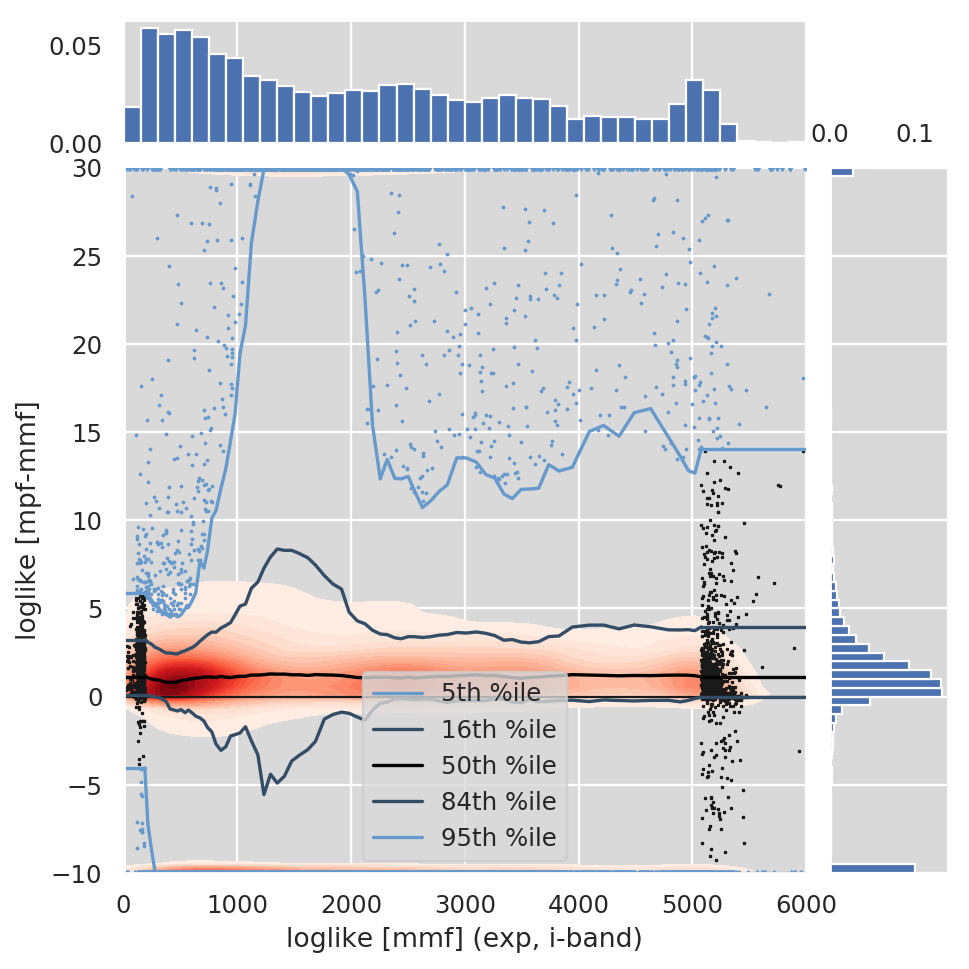

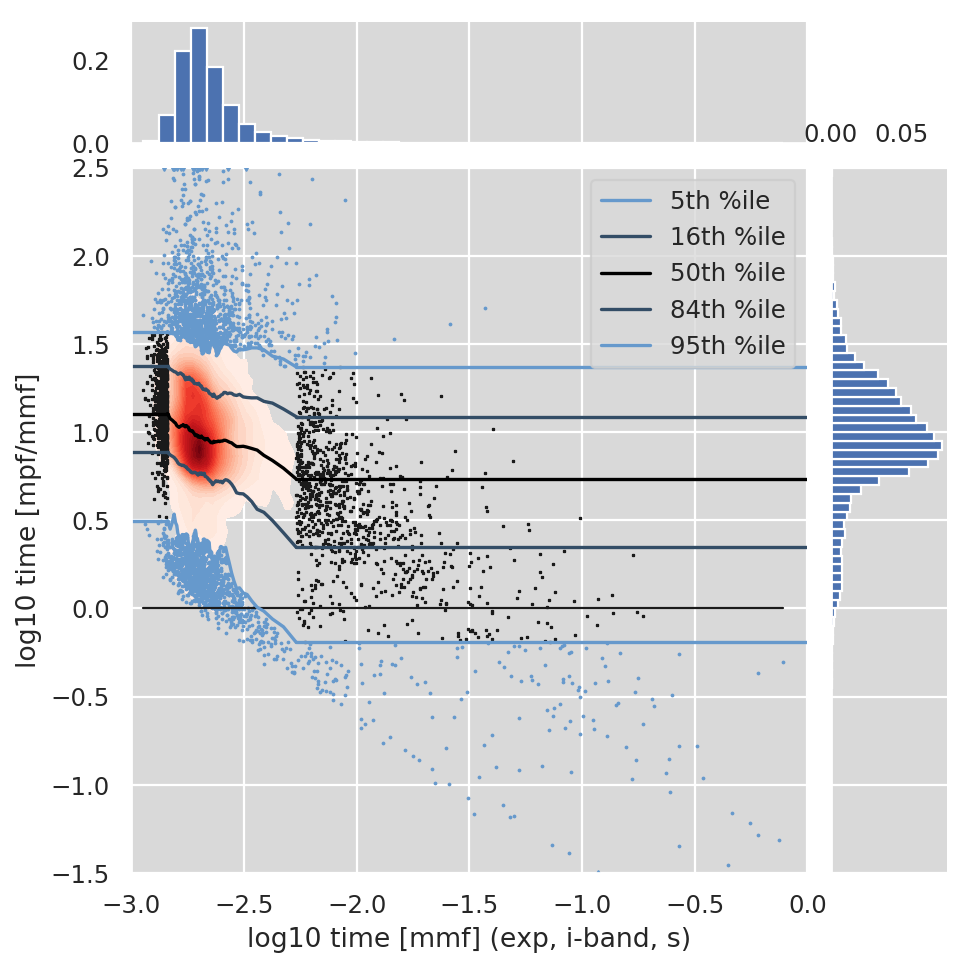

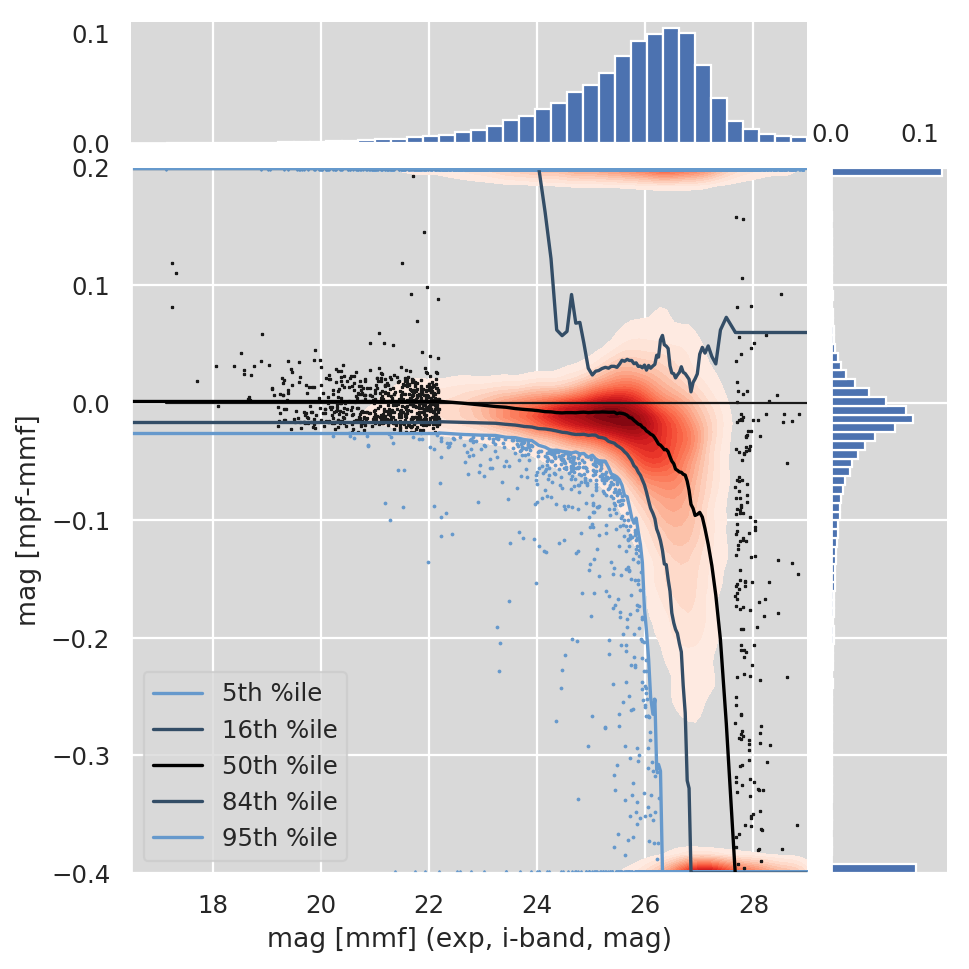

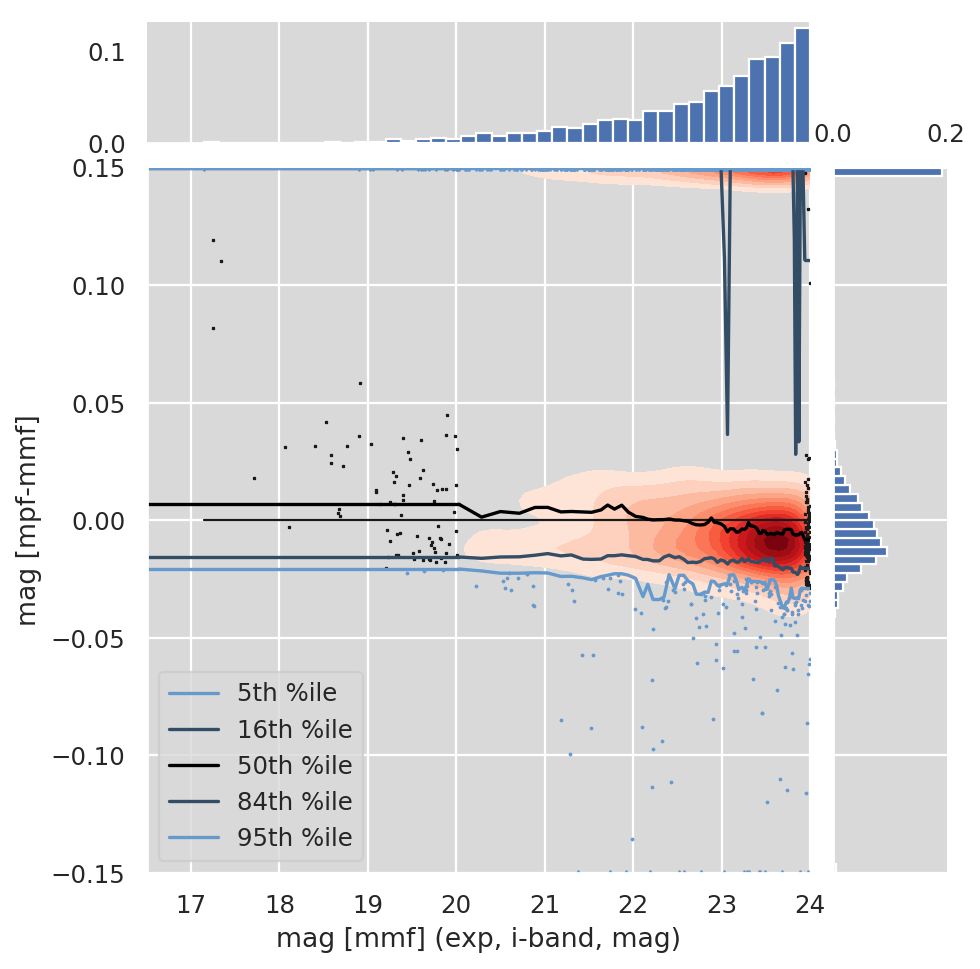

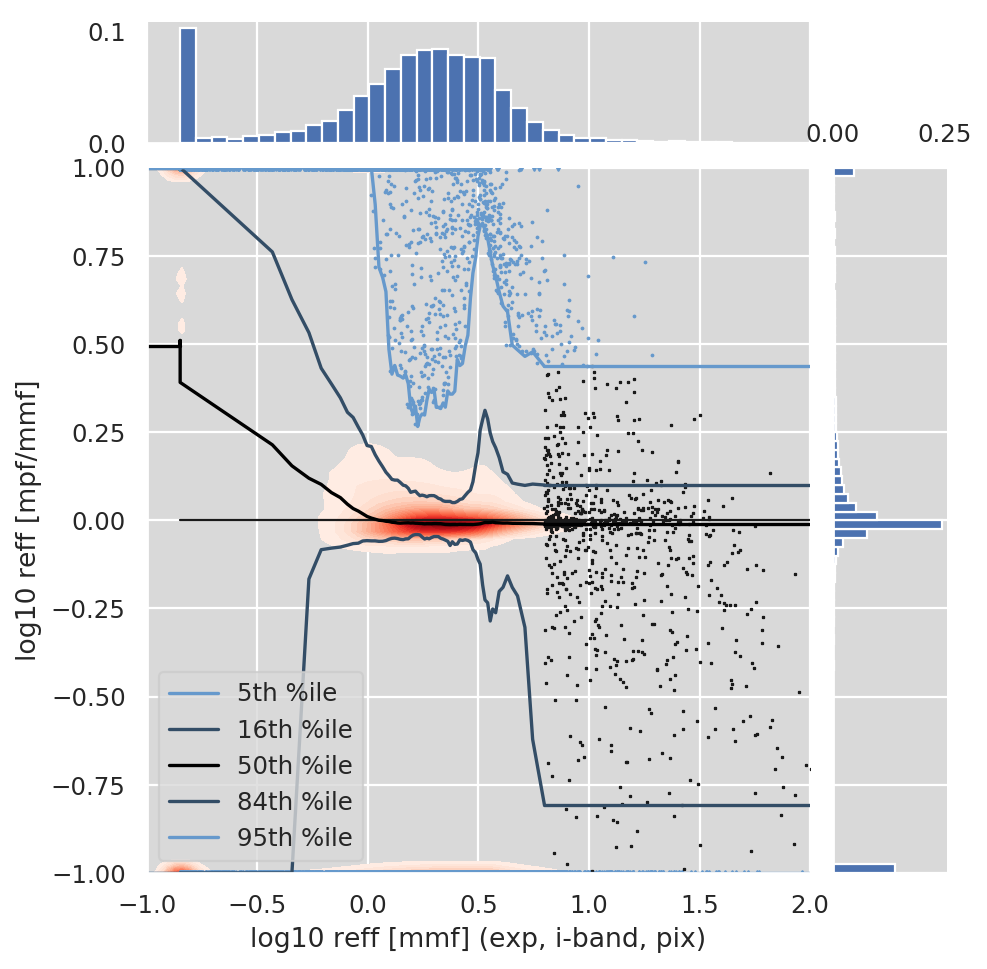

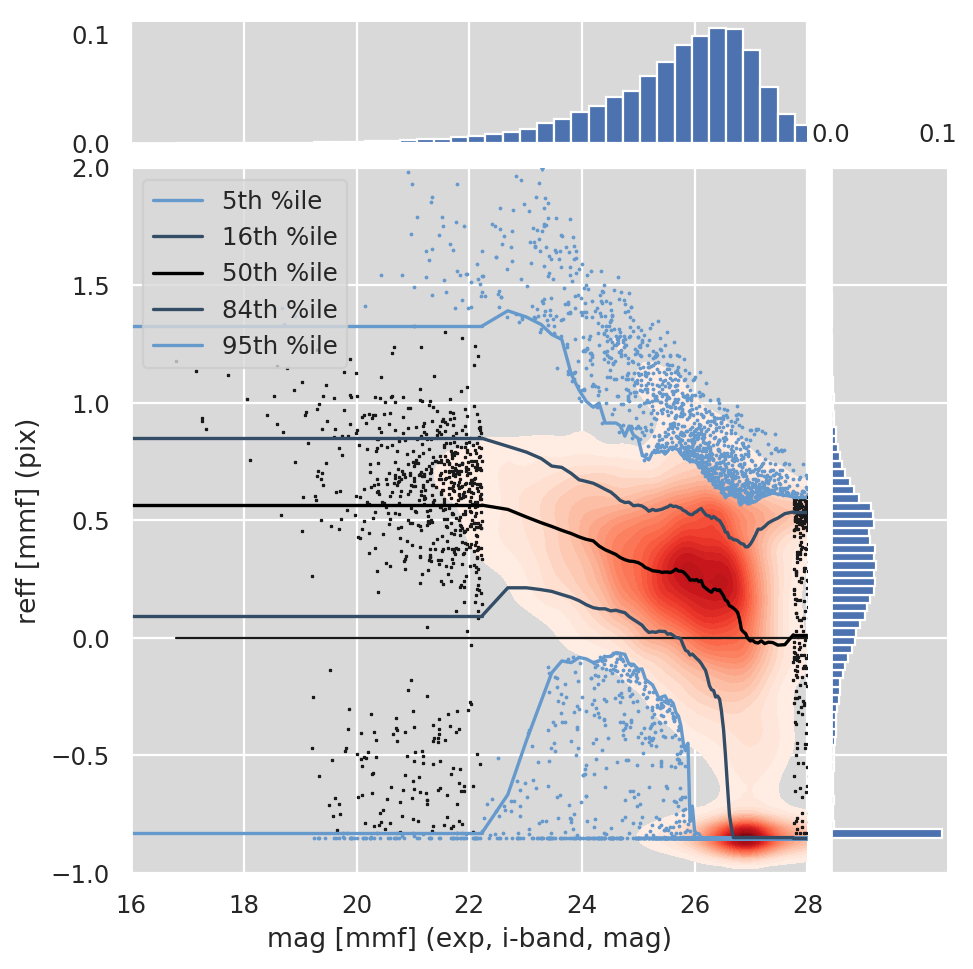

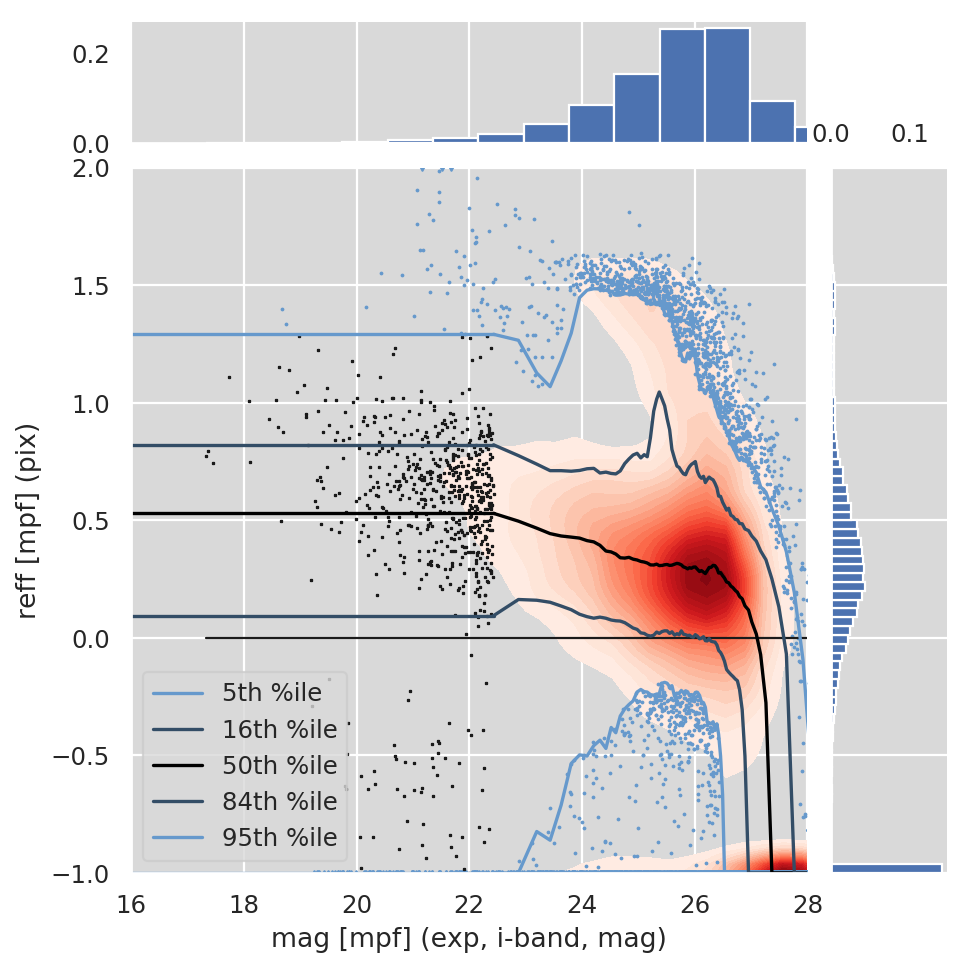

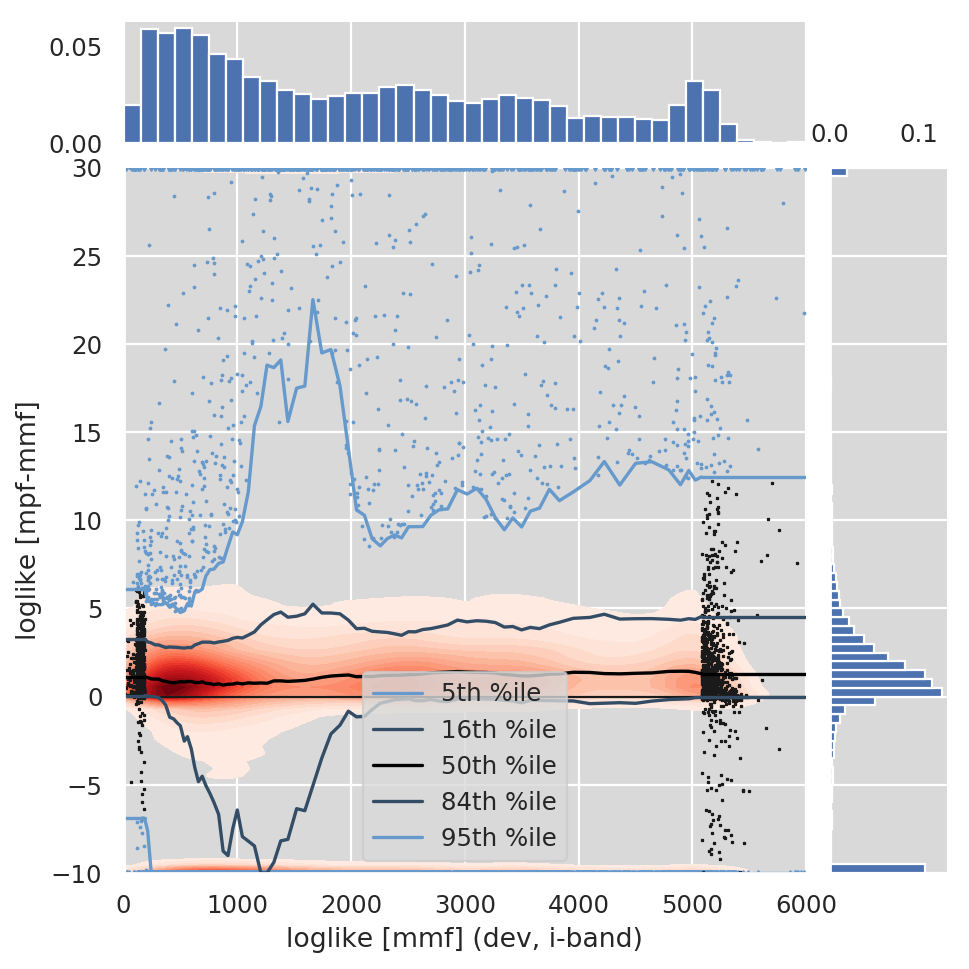

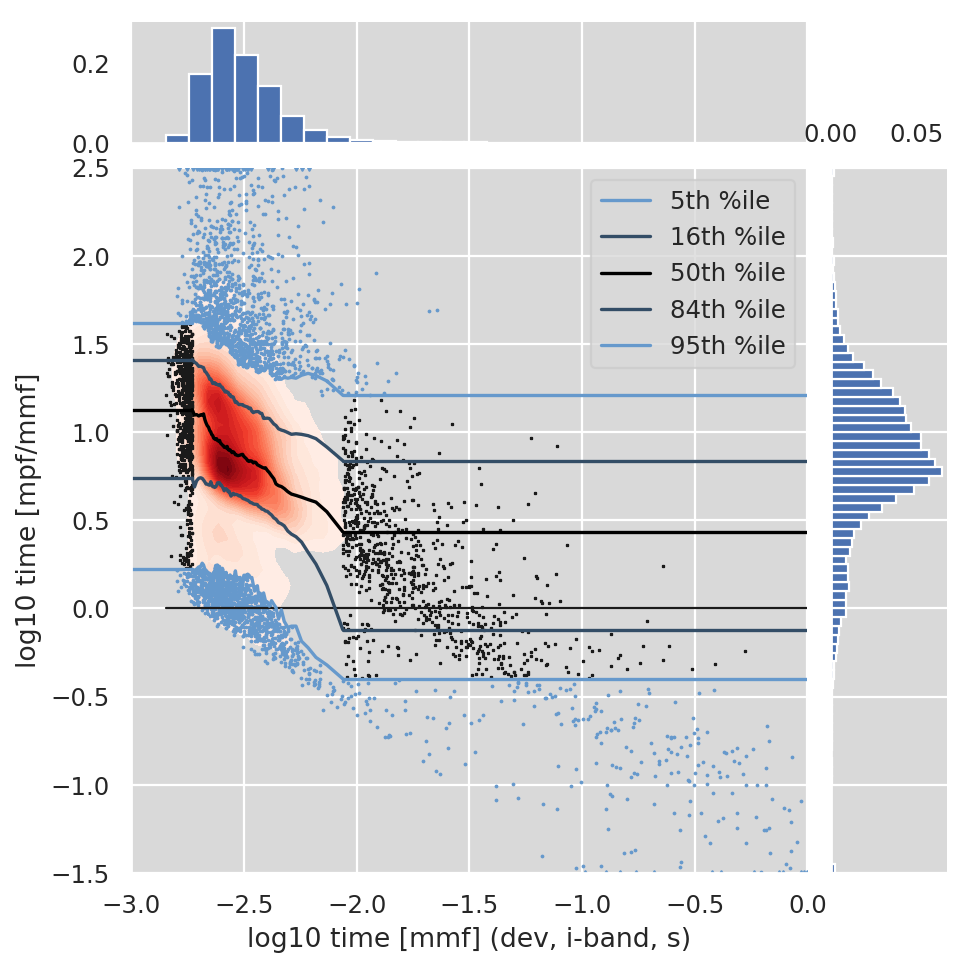

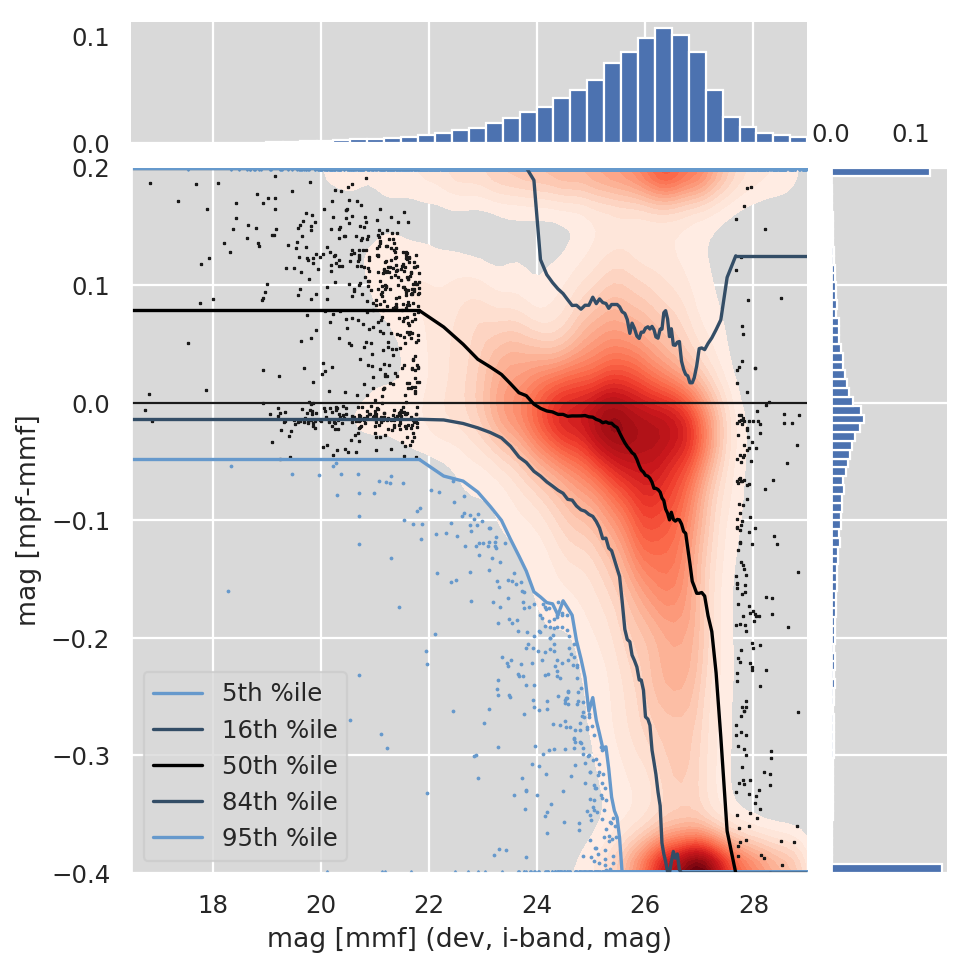

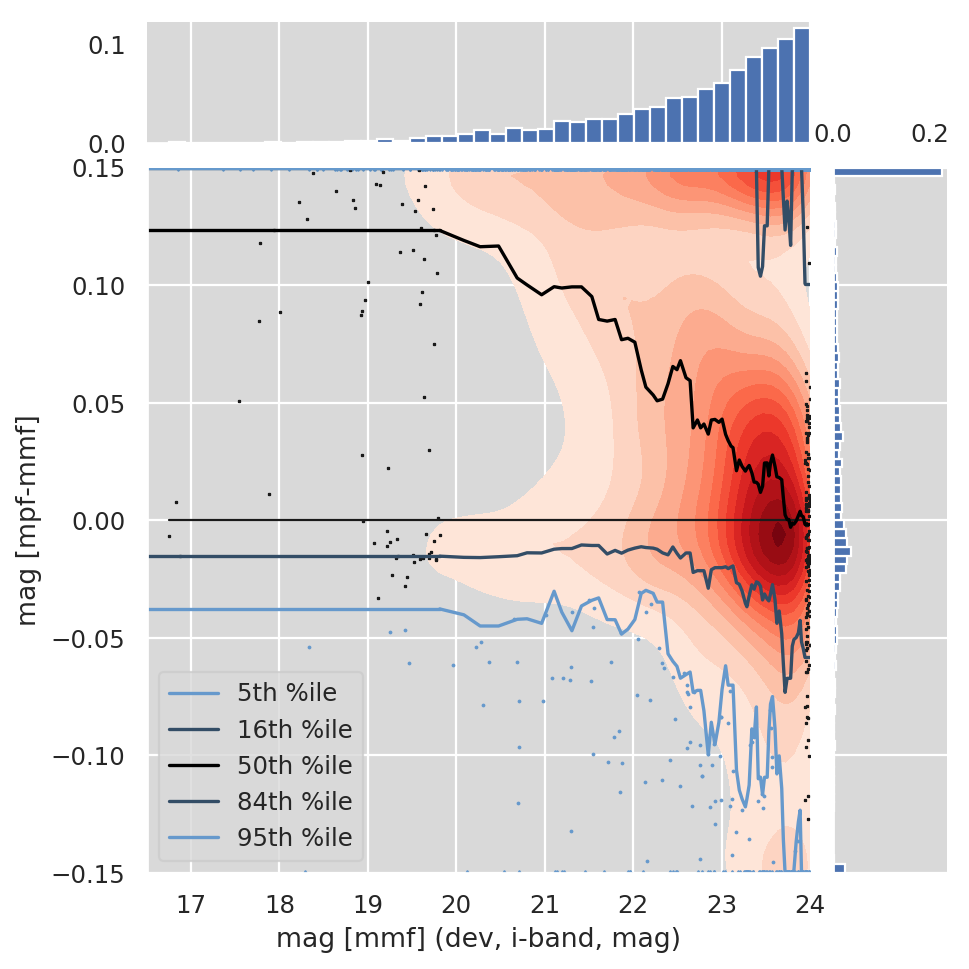

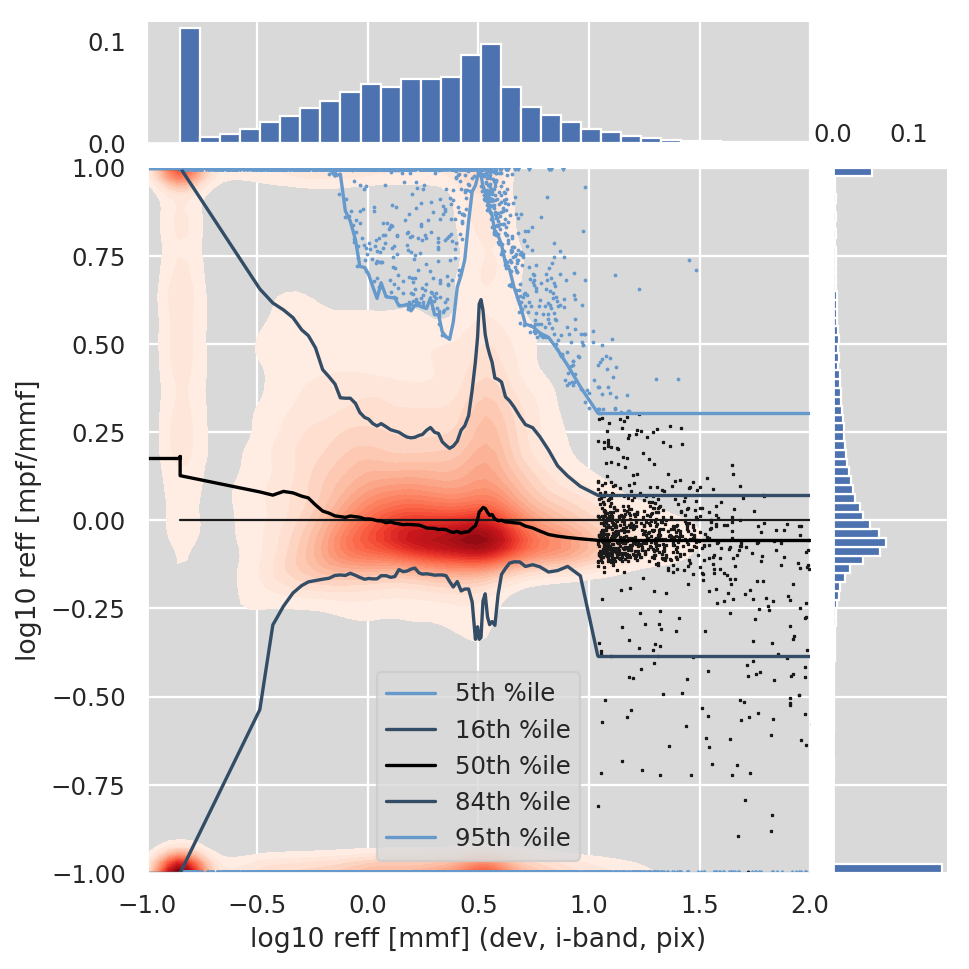

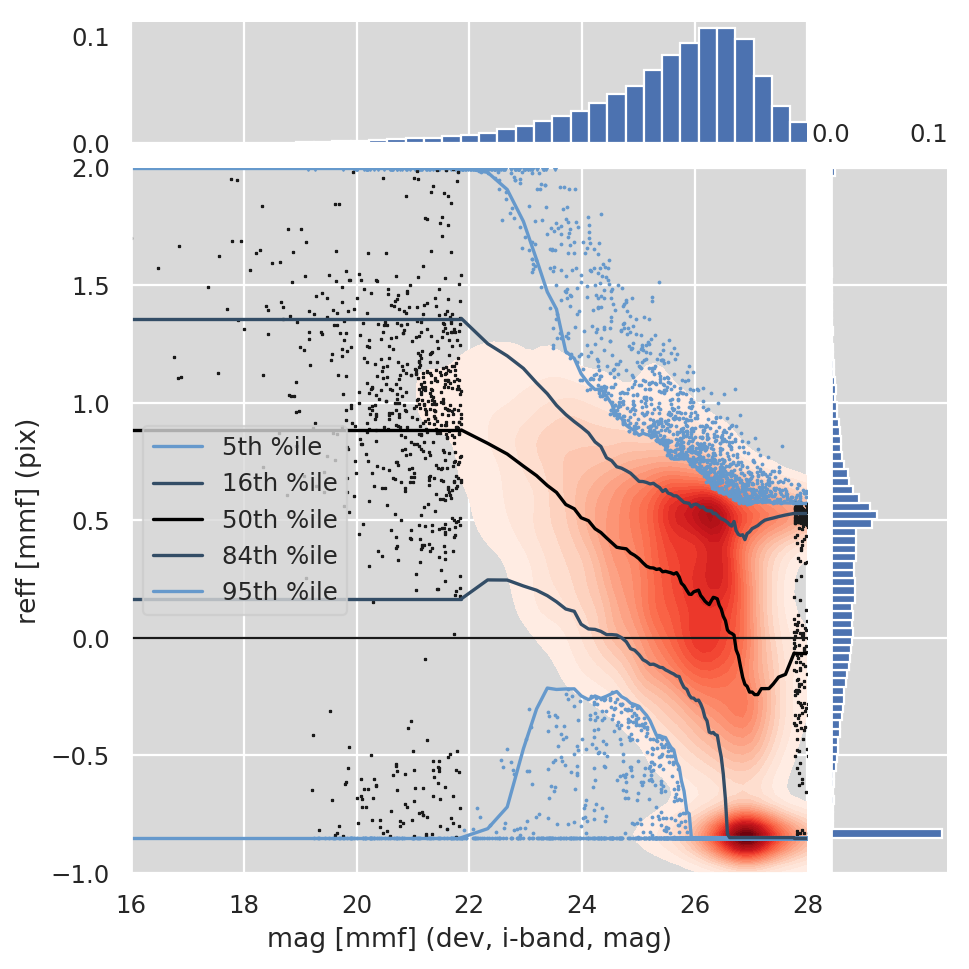

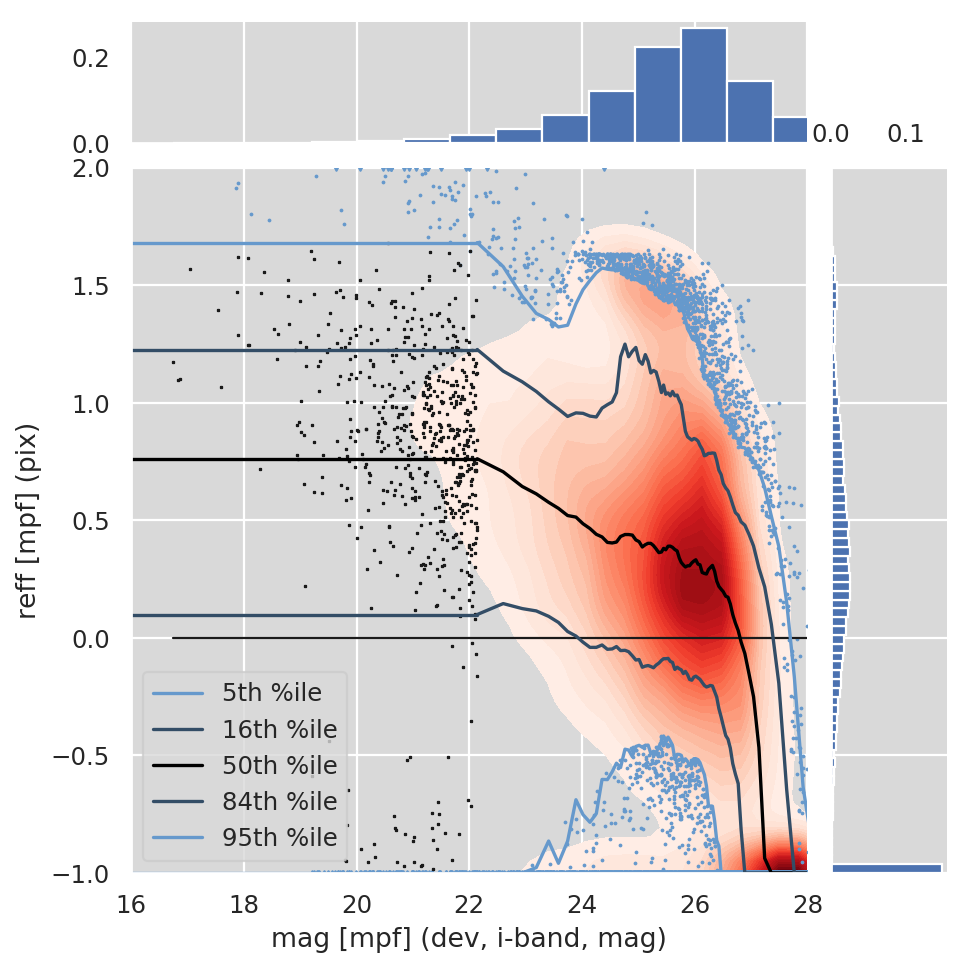

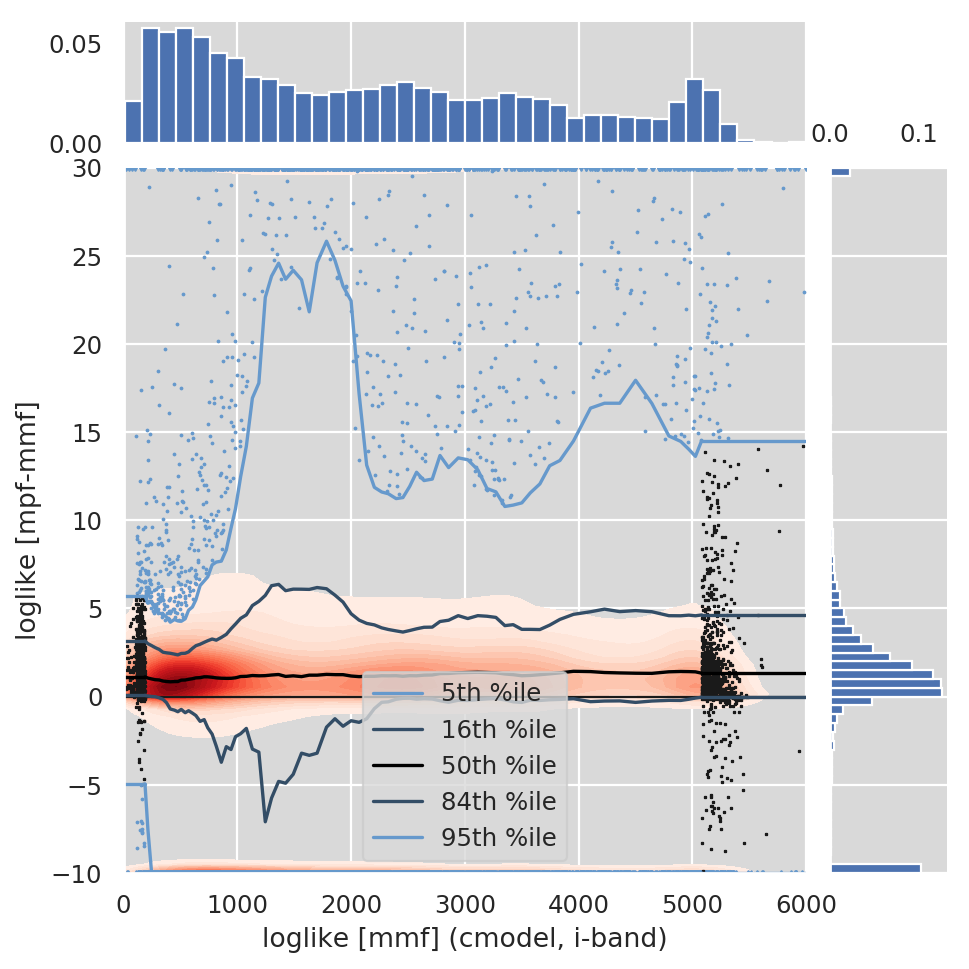

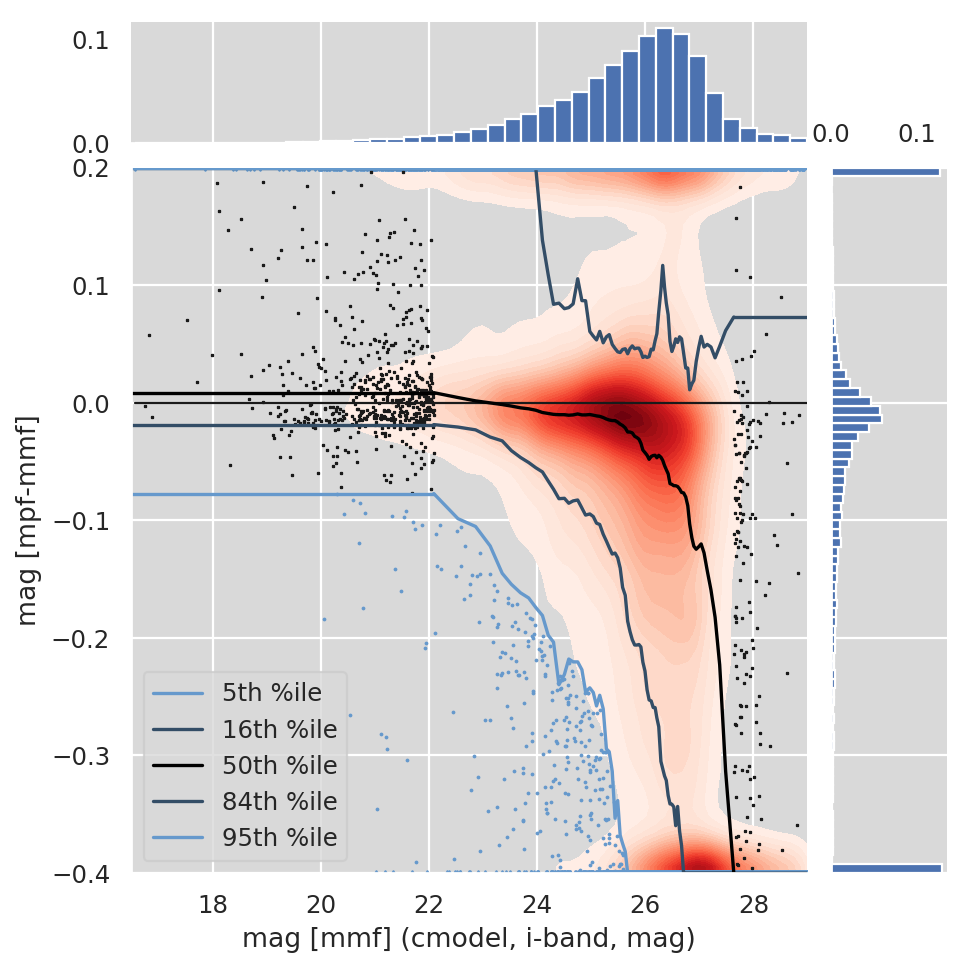

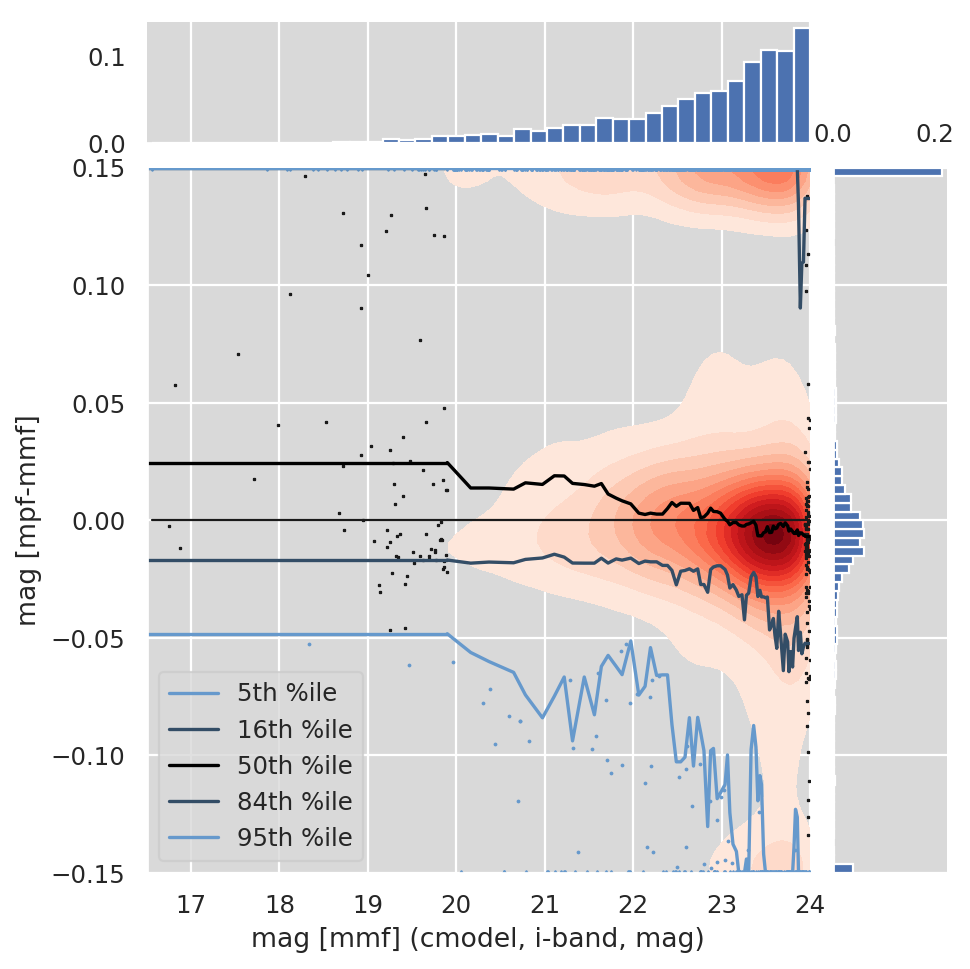

In [8]:
plot_models(data, "i", ("mmf", "mpf"), columns_plot, columns_plot_size)

## Comparing i-band meas_modelfit vs MultiProFit multiband

To be clear, these are comparing only the i-band parameters from the MultiProFit gri simultaneous fit. Some structural parameters are shared across bands (all of them for single Sersic fits). meas_modelfit is i-band only as before.

Right now the log likelihood plots are sadly useless because they include all bands for MultiProFit but only i-band for meas_modelfit.

Plotting model exp plot loglike
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 21245/34114 not finite for model, band=exp,gri


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in subtract


Plotting model exp plot time
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7311/34114 not finite for model, band=exp,gri


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in true_divide
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10


Plotting model exp plot mag
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7311/34114 not finite for model, band=exp,gri
Plotting model exp plot mag_bright
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 30832/34114 not finite for model, band=exp,gri
Plotting model exp plot reff
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7311/34114 not finite for model, band=exp,gri
(array([], dtype=int64),)


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


Plotting model exp plot mag_reff_mmf
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7206/34114 not finite for model, band=exp,gri
Plotting model exp plot mag_reff_mpf
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7311/34114 not finite for model, band=exp,gri
Plotting model dev plot loglike
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 21335/34114 not finite for model, band=dev,gri
Plotting model dev plot time
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7310/34114 not finite for model, band=dev,gri
Plotting model dev plot mag
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7310/34114 not finite for model, band=dev,gri
Plotting model dev plot mag_bright
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 30253/34114 not finite for model, band=dev,gri
Plotting model dev plot reff
[0.95627503 1.01691985 1.0211888  ...        nan        nan    

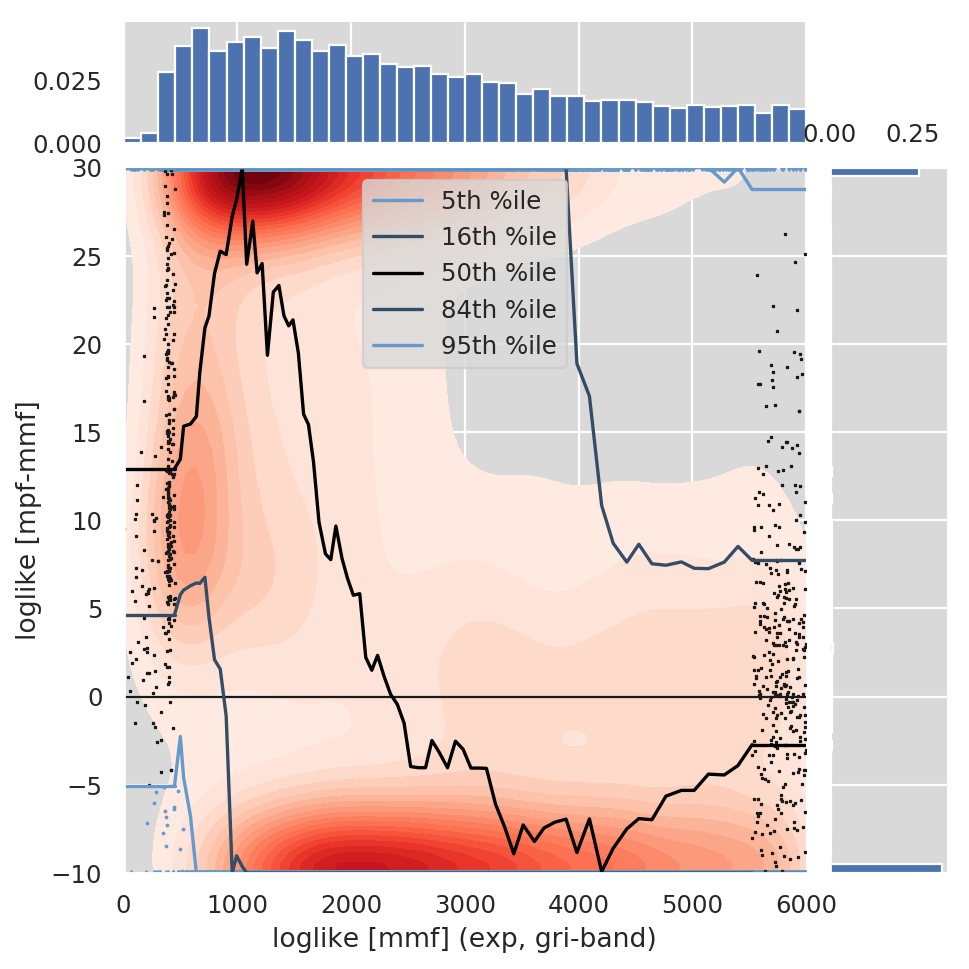

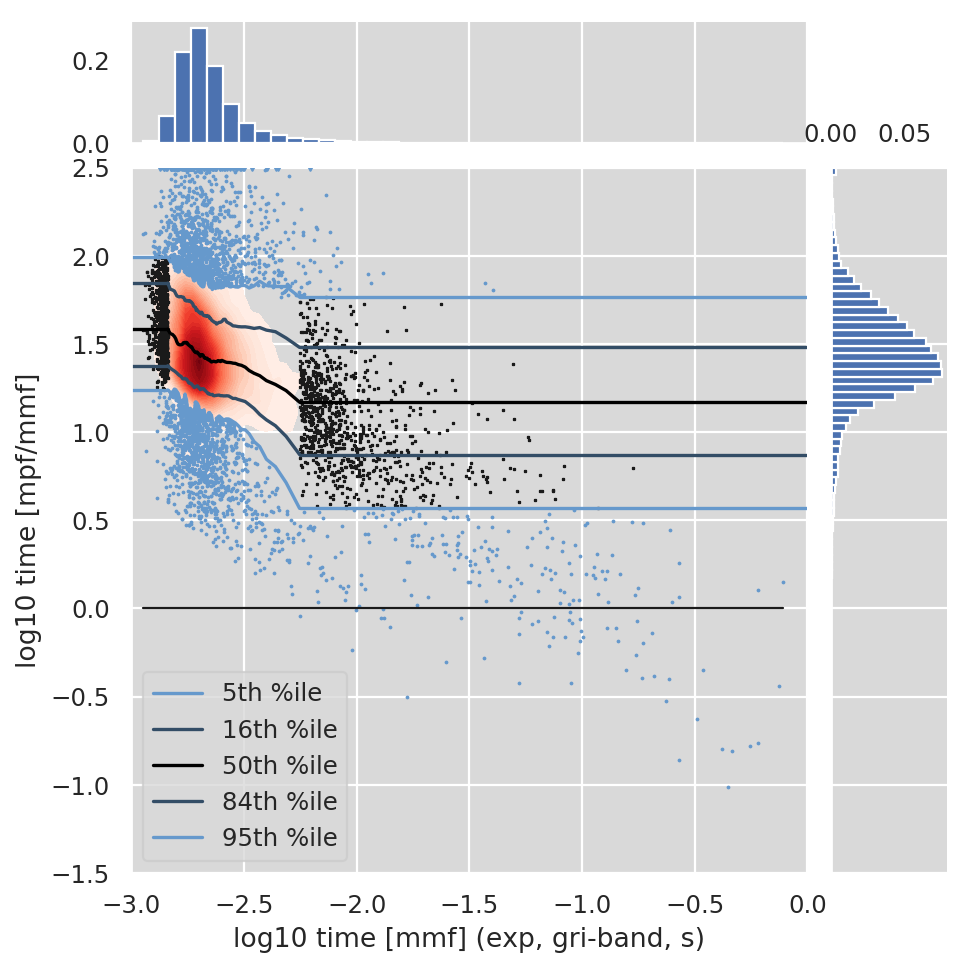

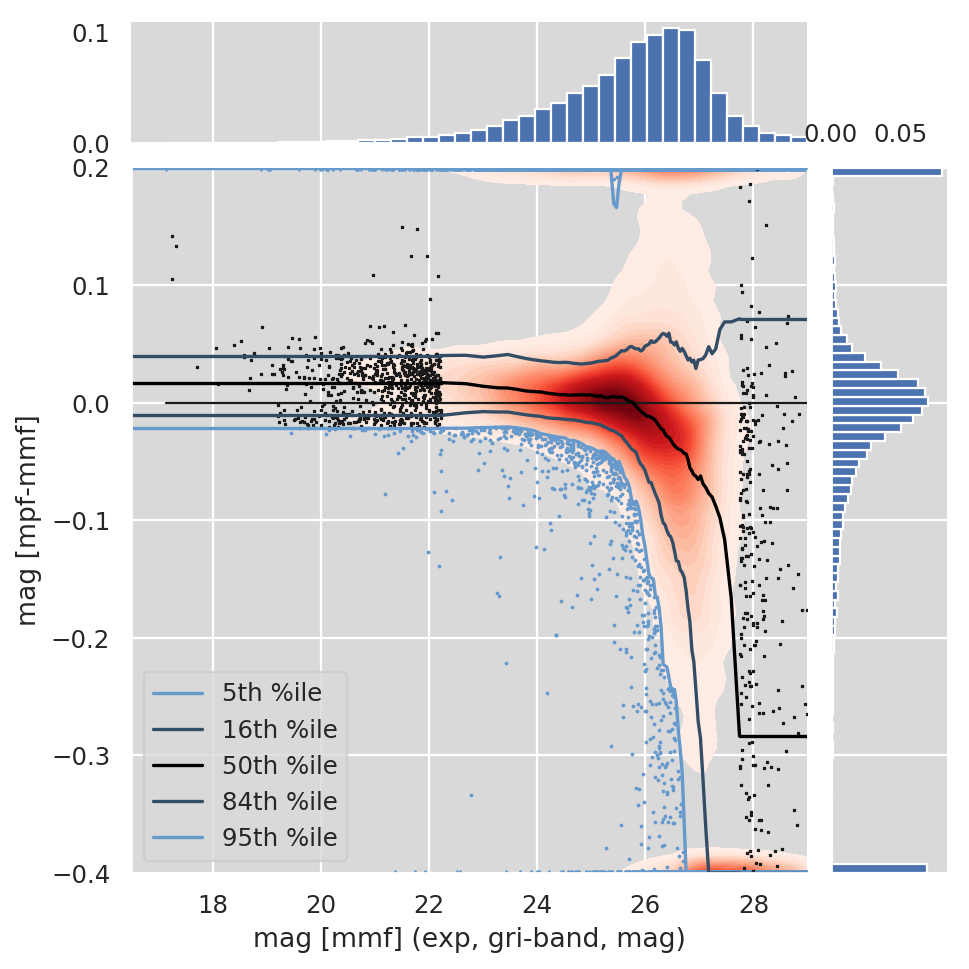

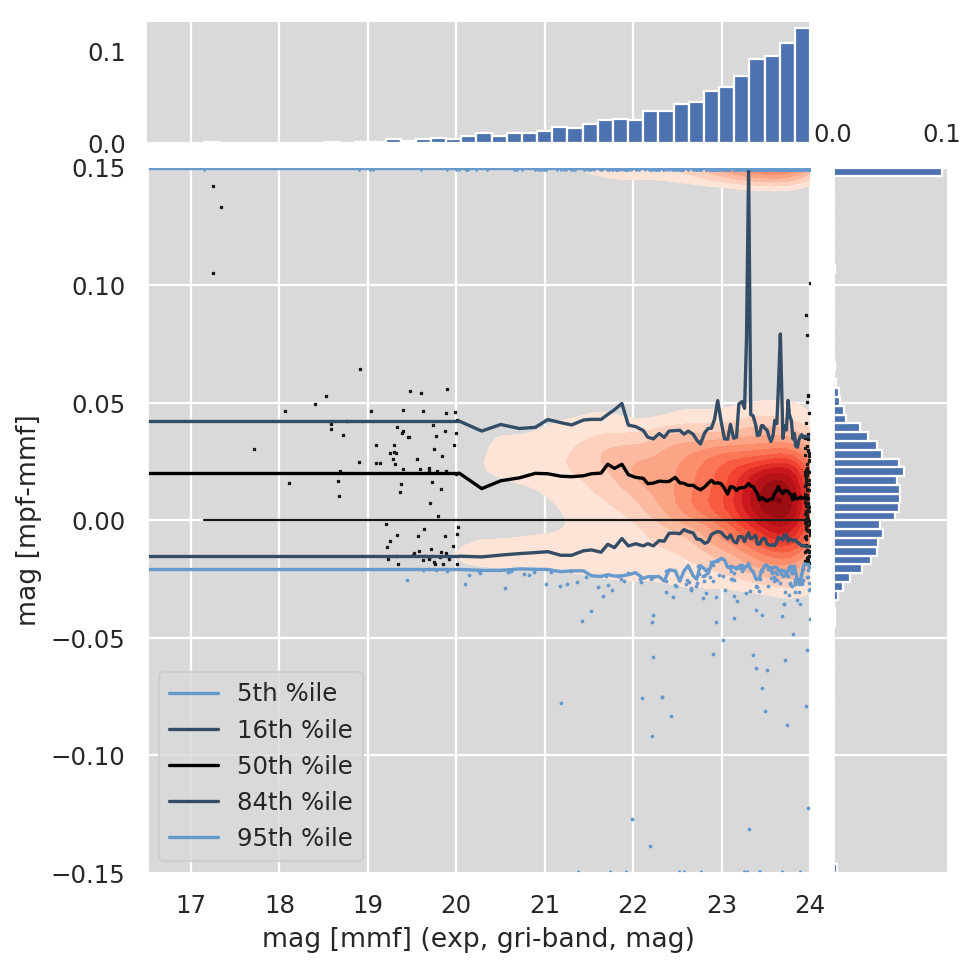

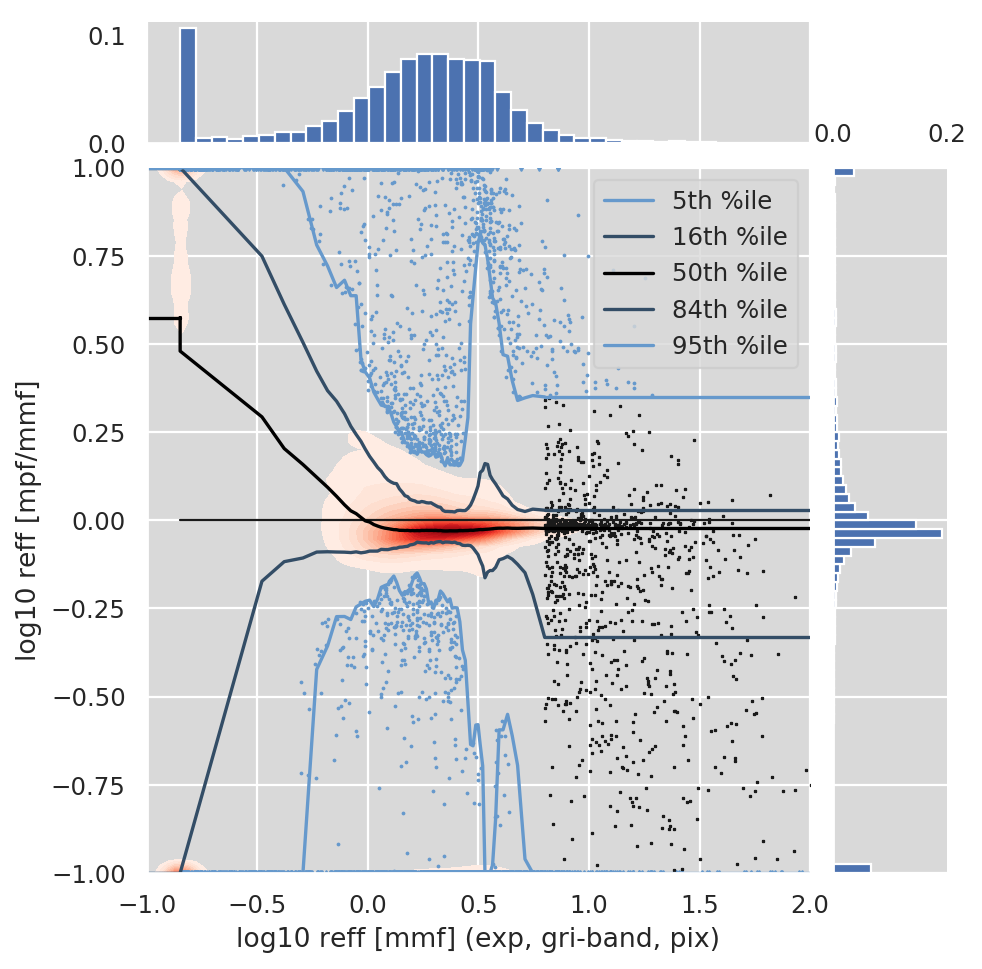

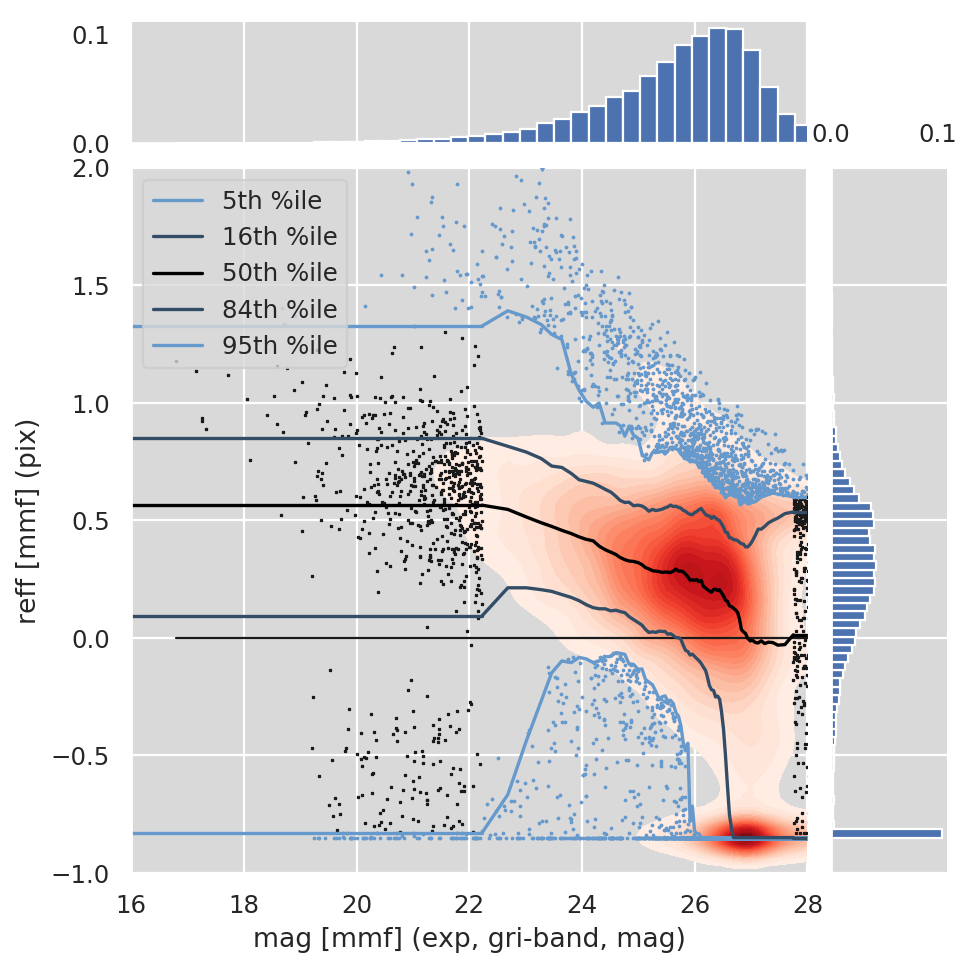

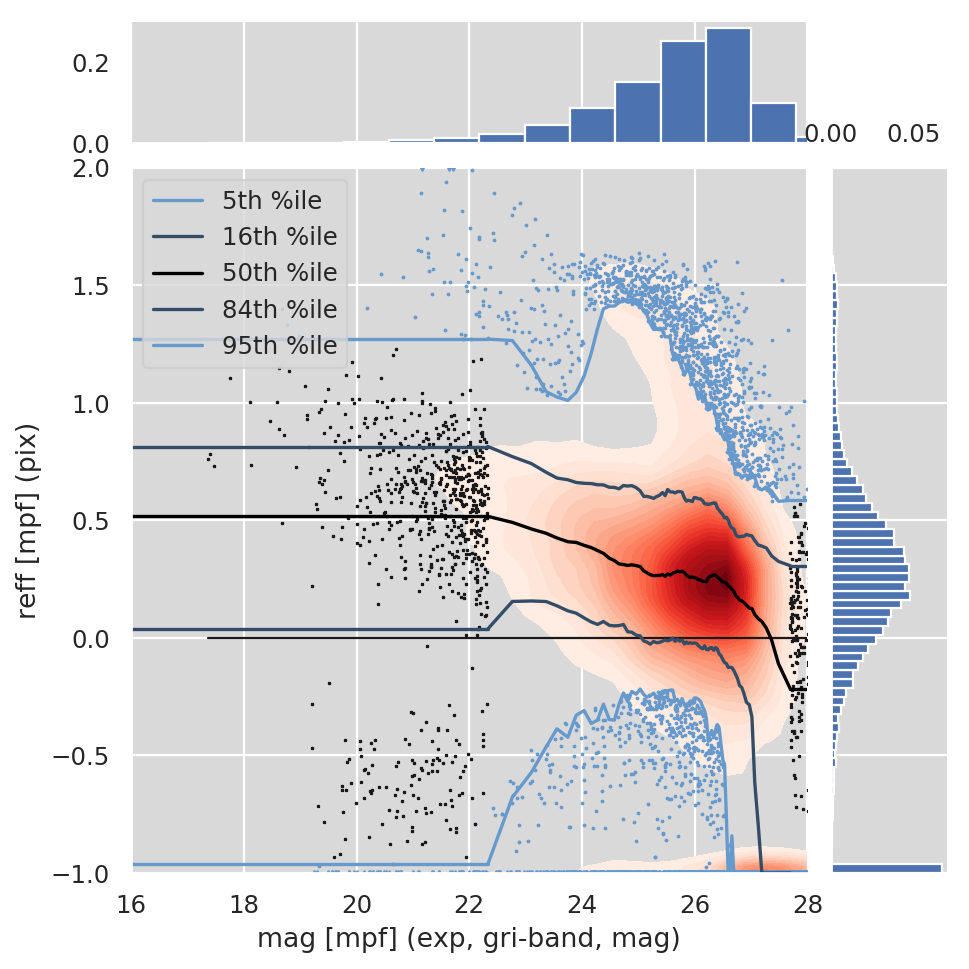

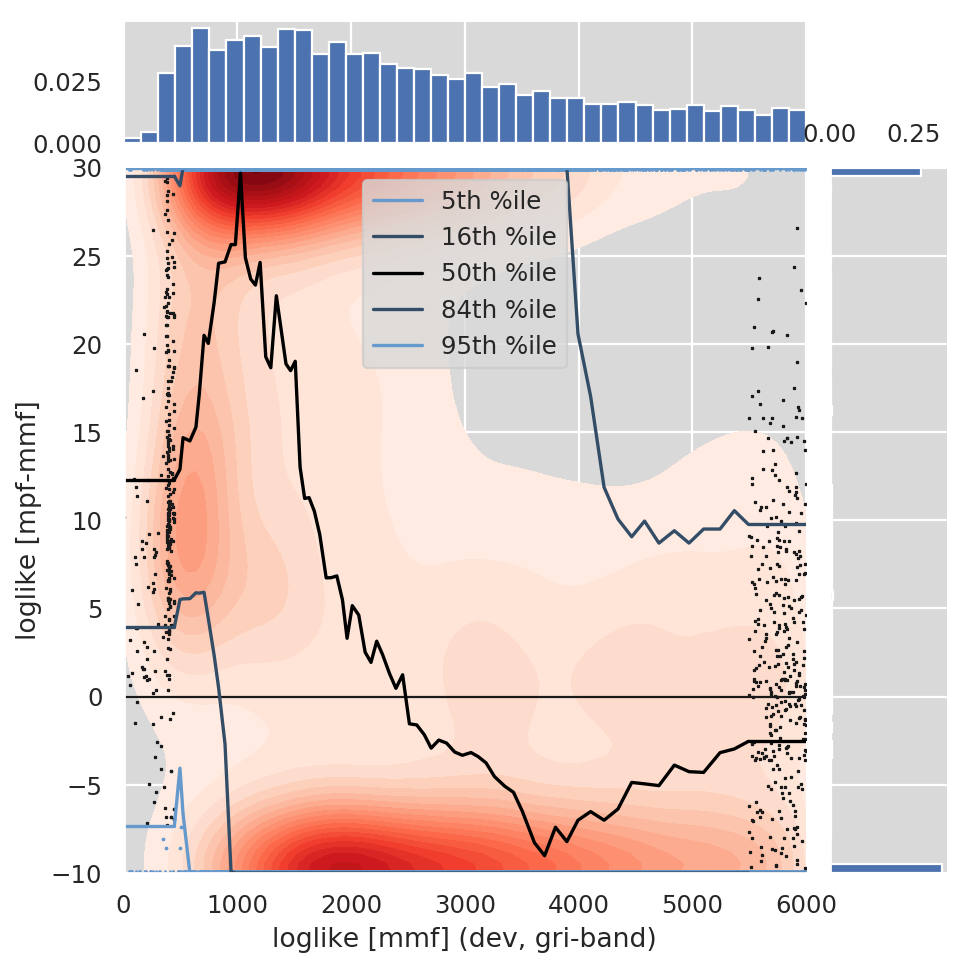

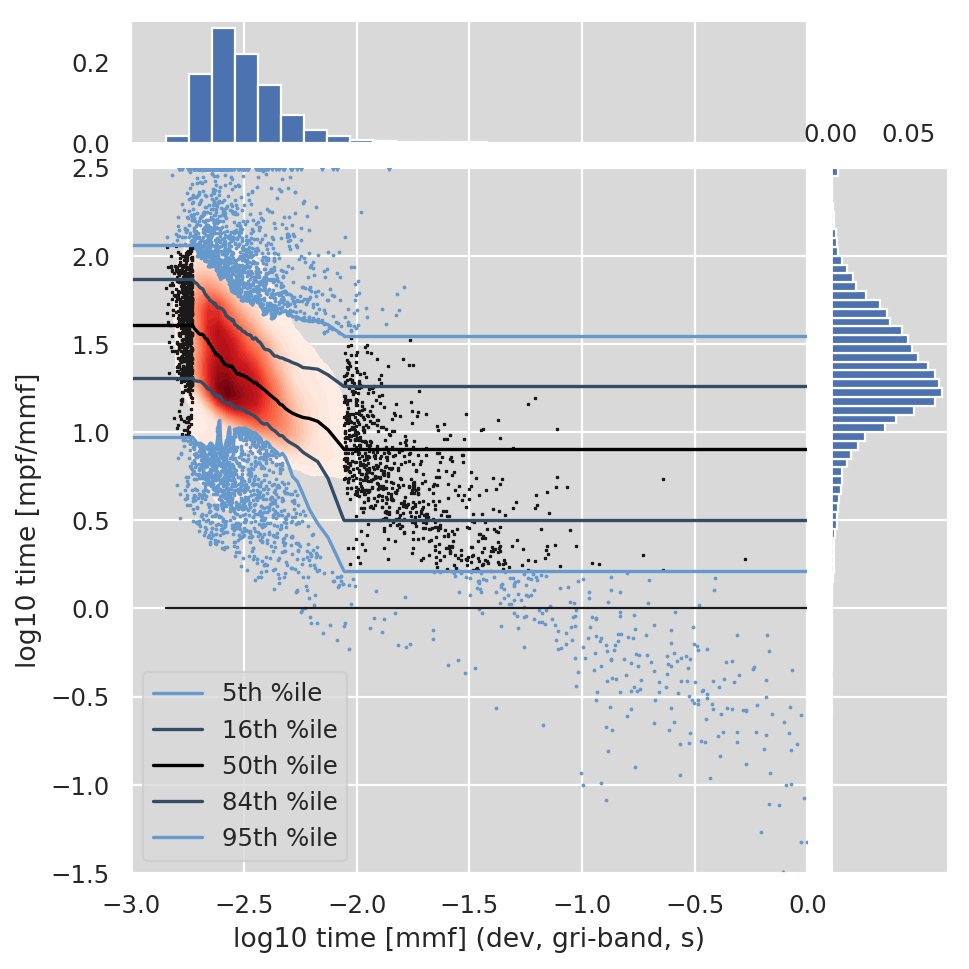

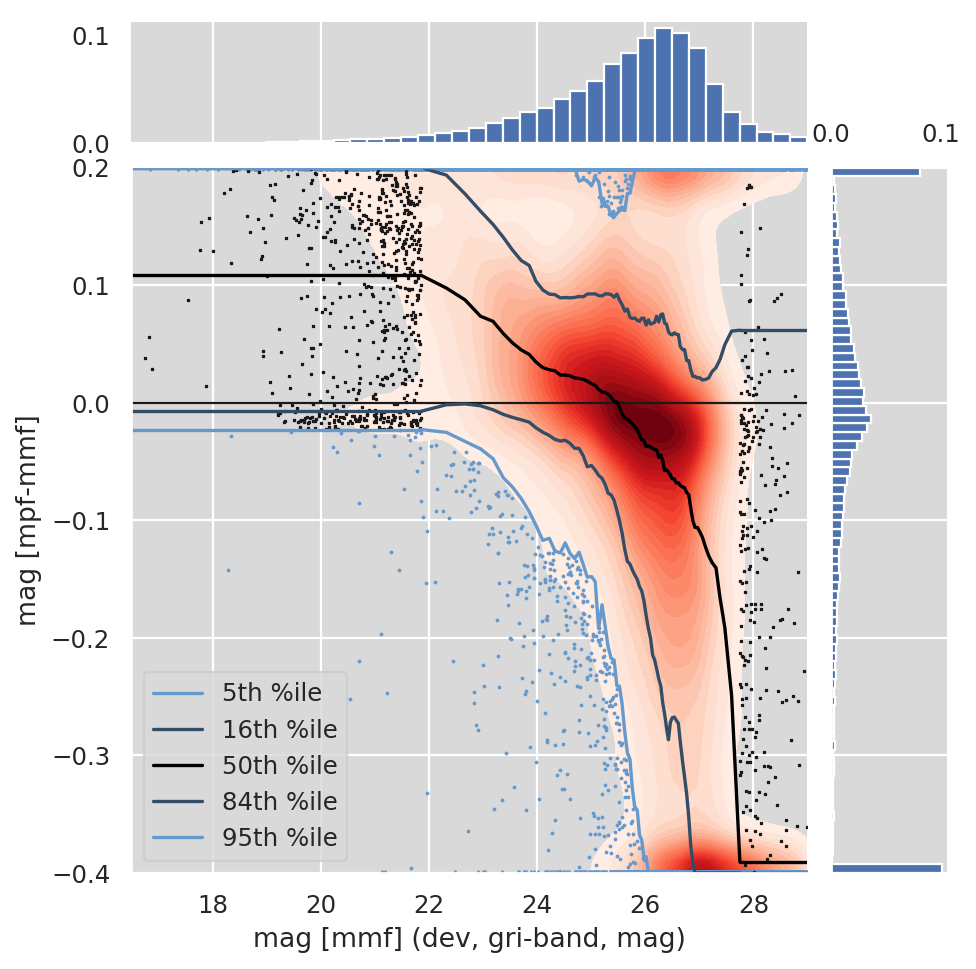

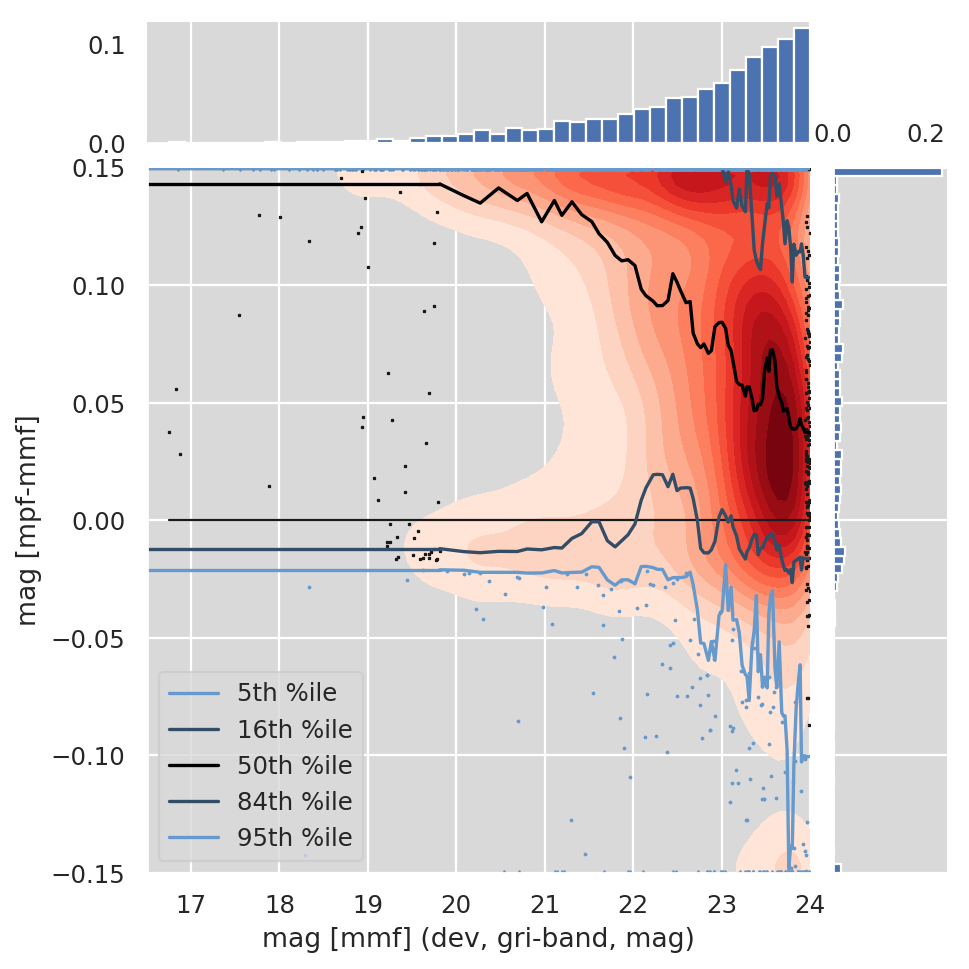

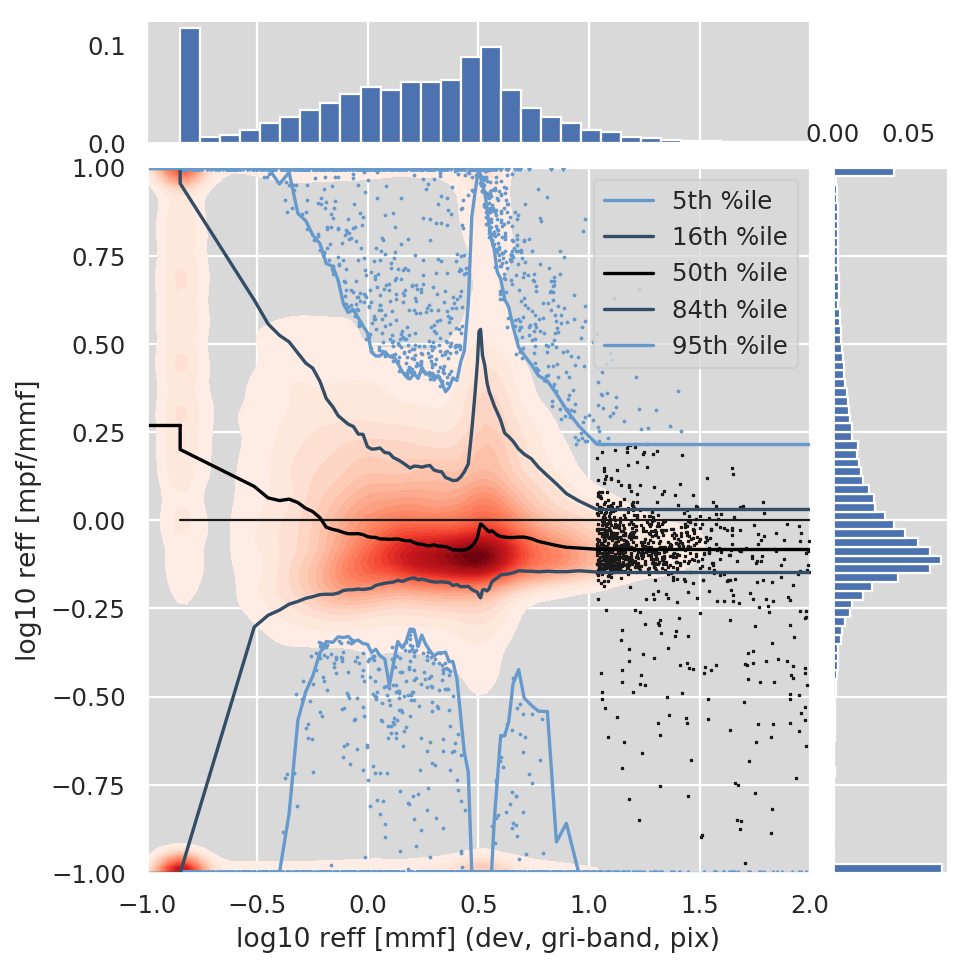

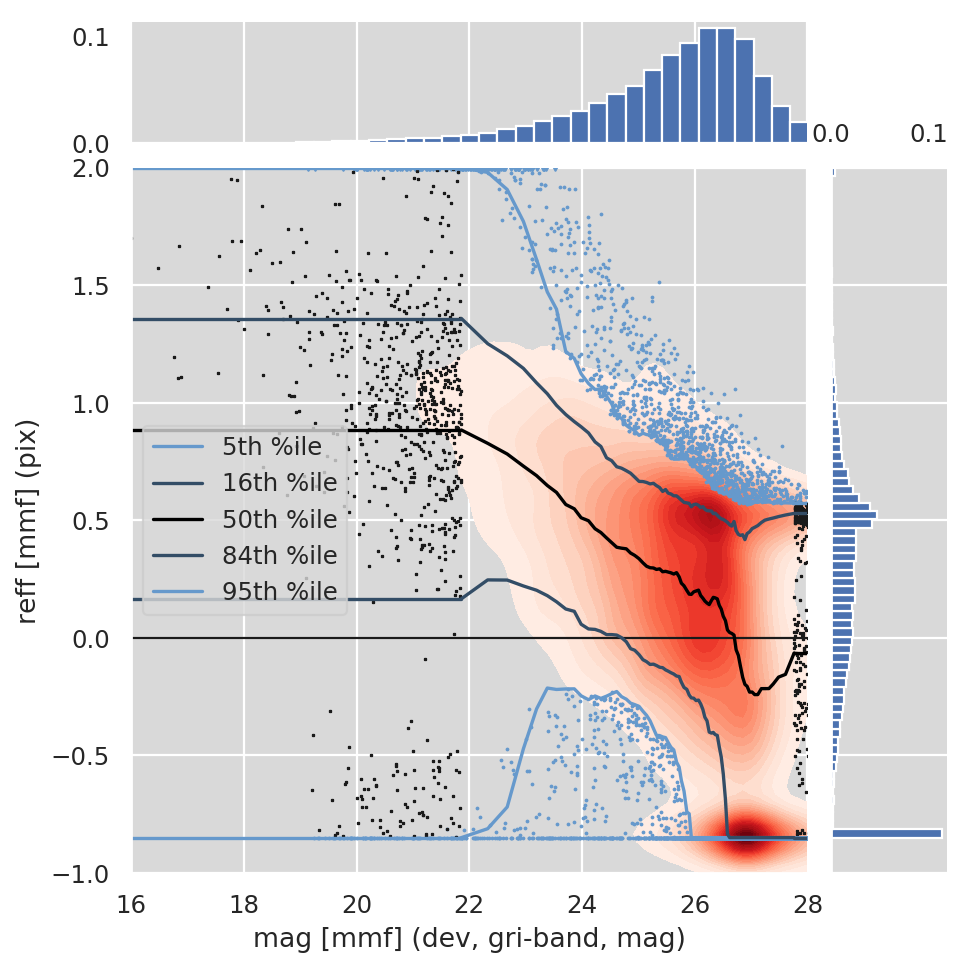

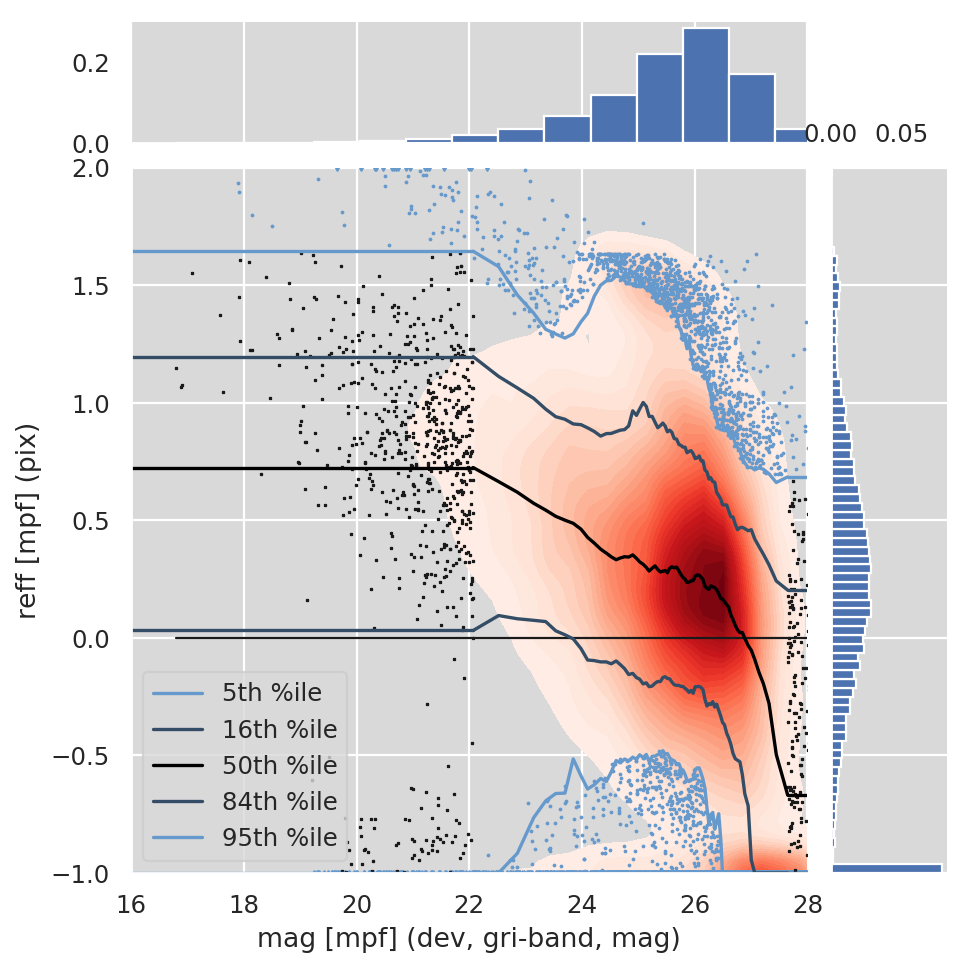

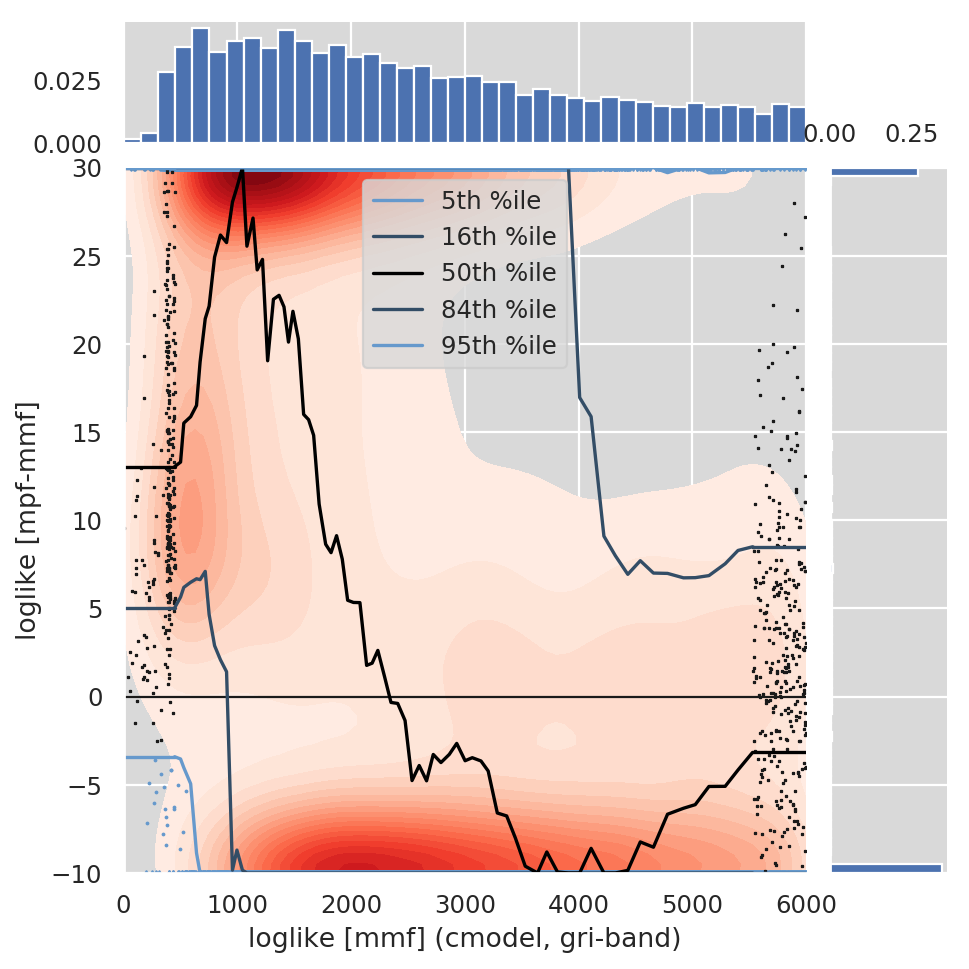

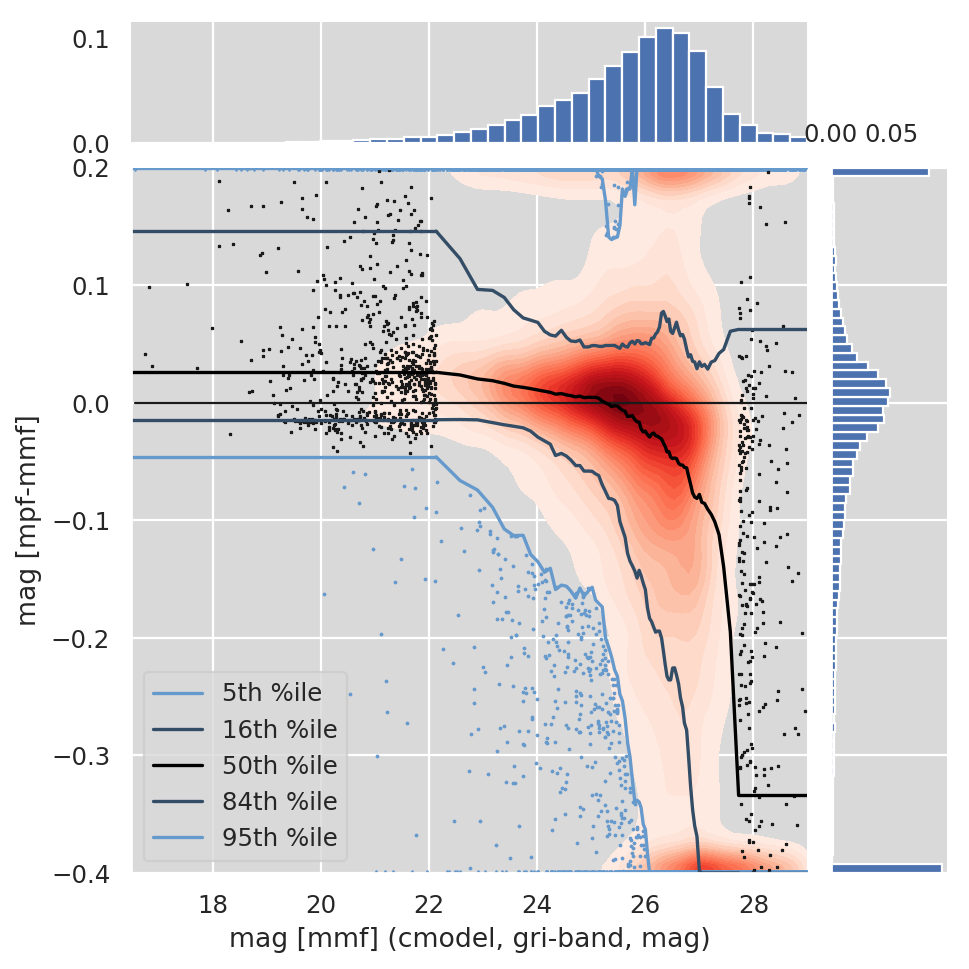

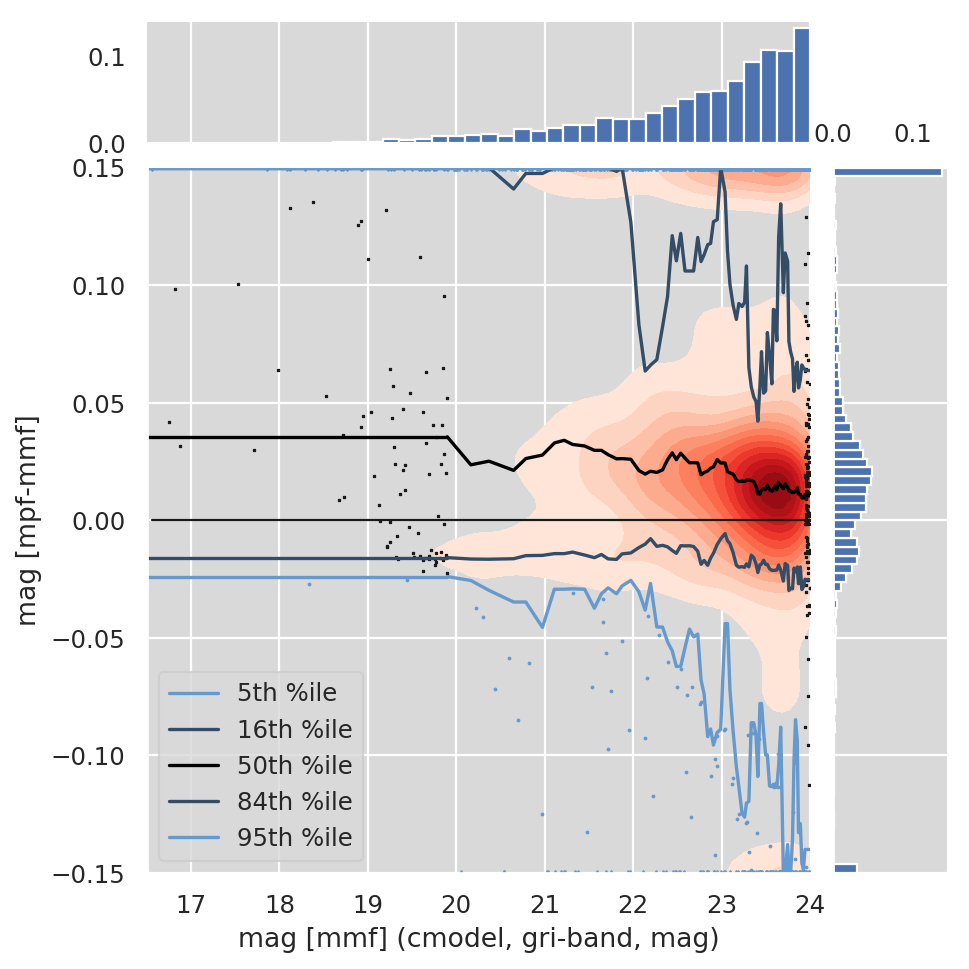

In [9]:
plot_models(data, "gri", ("mmf", "mpf"), columns_plot, columns_plot_size)

## Comparing gri-band MultiProFit CModel vs MG Sersic fits

As before, these are comparing only the i-band parameters, although gri are fit simultaneously.

In [10]:
columns_plot_size_algo = columns_plot.copy()
columns_plot_size_algo.update({
    "reff": dict(postfix="_1", log=True, ratio=True, limx=(-1, 2), limy=(-1, 1)),
    "mag_reff": dict(postfix="_1", log_y=True, limx=(16, 28), limy=(-1, 2),
                      column="mag", column_y="reff", datum_idx_x=1),
})

def plot_models_algo(data, band, algo, models, columns_plot, columns_plot_size_algo):
    data_band = data[band]
    data_models = [data_band[model] for model in models]
    is_single_comps = [model != "cmodel" for model in models]
    is_single_comp = all([model != "cmodel" for model in models])
    data_algos = [data_model[algo] for data_model in data_models]
    cond = (data_algos[0]['mag_1'] < 28)*(data_algos[0]["modelfit_CModel_flag"] == 0)*(data_algos[0]["deblend_tooManyPeaks"] == 0)
    for name_plot, column_info in (columns_plot_size if is_single_comp else columns_plot).items():
        column_x, column_y, name_column_x, name_column_y, datum_idx_x, datum_idx_y = \
            get_columns_info(column_info, name_plot)
        try:
            x = data_algos[0][column_x]
            y = data_algos[1][column_y]
            plot_column_pair(x, y, cond, column_info, column_x, column_y, name_column_x, name_column_y, models[0], models[1], name_plot, algo, band, units)
        except Exception as e:
            print(data_algos[0].keys(), data_algos[1].keys(), column_x, column_y)
            data_model_names = [f"data['{band}']['{model}']" for model in models]
            print(data_model_names)
            print(f"Failed to read {data_model_names[0]}['{algo}']['{column_x}'] and/or "
                  f"{data_model_names[1]}['{algo}']['{column_y}'] "
                  f"due to {getattr(e, 'message', repr(e))}")
                #print(traceback.format_exc())

/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in subtract


[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 21497/34114 not finite for model, band=mpf,gri
dict_keys(['mag_1', 'loglike_1', 'deblend_tooManyPeaks', 'modelfit_CModel_flag', 'fracDev']) dict_keys(['mag_1', 'sigma_x_1', 'sigma_y_1', 'rho_1', 'nser_1', 'loglike_1', 'chisqred_1', 'deblend_tooManyPeaks', 'modelfit_CModel_flag', 'time', 'reff_1']) time time
["data['gri']['cmodel']", "data['gri']['mg8serb']"]
Failed to read data['gri']['cmodel']['mpf']['time'] and/or data['gri']['mg8serb']['mpf']['time'] due to KeyError('time')
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7279/34114 not finite for model, band=mpf,gri


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less


[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 30899/34114 not finite for model, band=mpf,gri


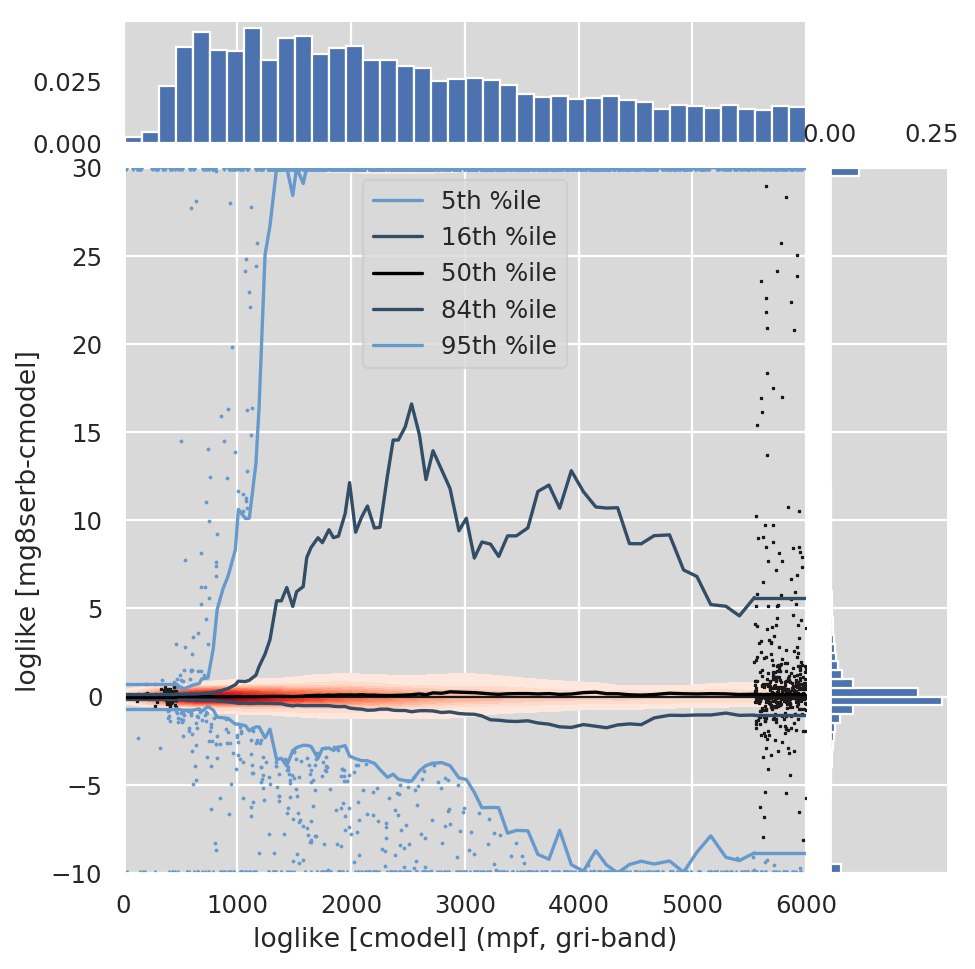

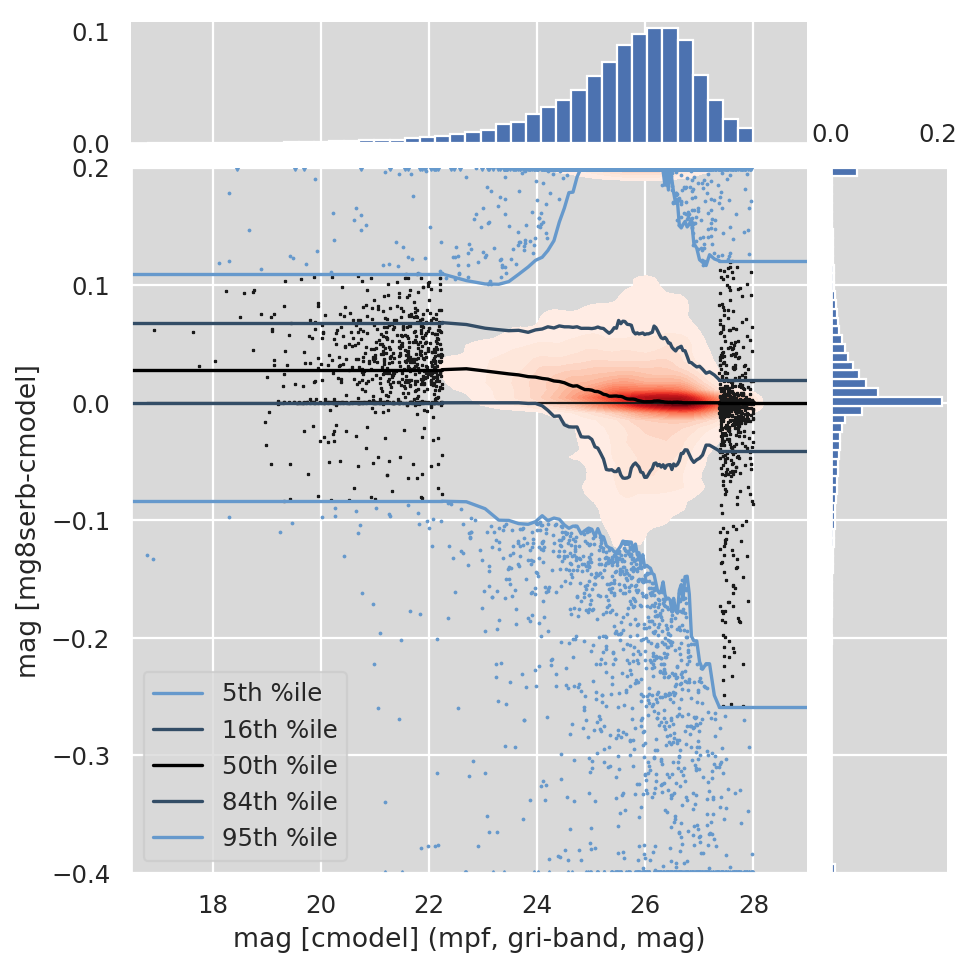

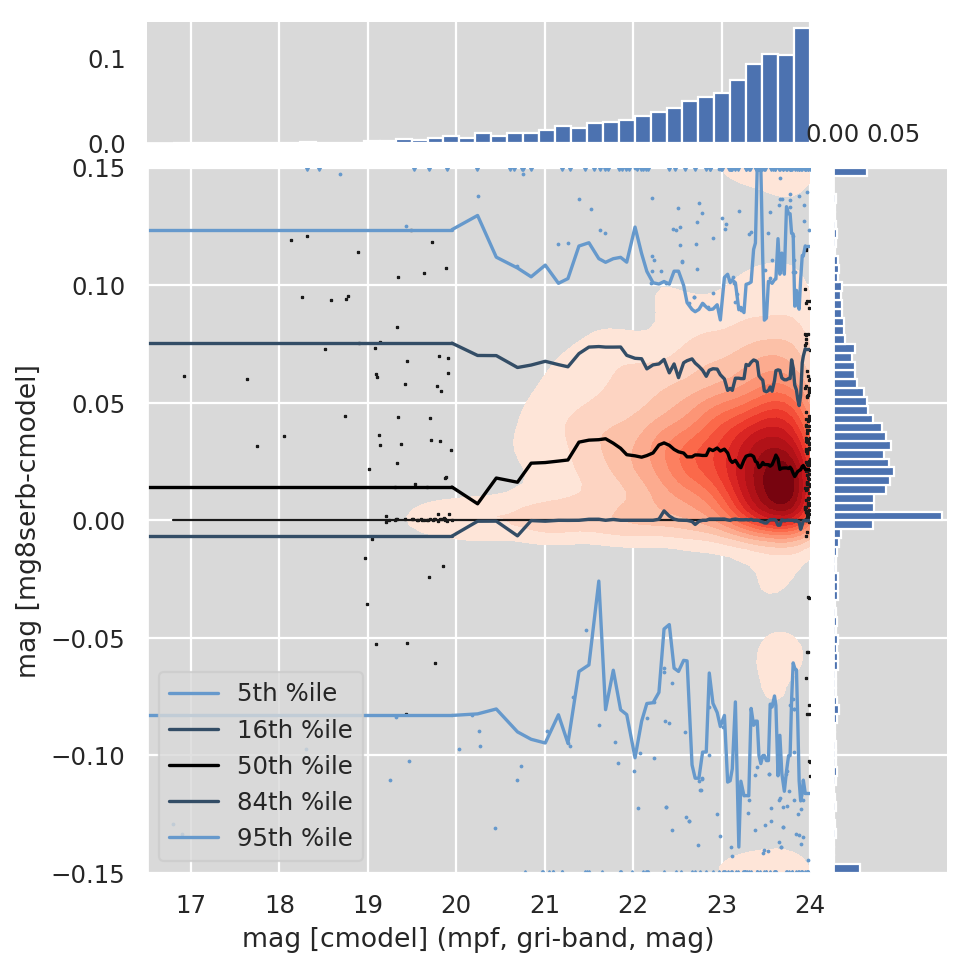

In [11]:
plot_models_algo(data, "gri", "mpf", ("cmodel", "mg8serb"), columns_plot, columns_plot_size_algo)

## Comparing gri-band MultiProFit MG Sersic initialization methods

As before, these are comparing only the i-band parameters, although gri are fit simultaneously.
mg8serb is initialized from the best fit out of the gauss, exp. and dev. fits, which are prerequisites for CModel.
mg8serm is initialized directly from the moments with n_ser=1 (exp.). This could be improved.

This is to test whether it is possible to initialize Sersic fits directly from the moments without having run any fixed-n fits (i.e. without running CModel).

/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in subtract


[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 21475/34114 not finite for model, band=mpf,gri
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7296/34114 not finite for model, band=mpf,gri
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7296/34114 not finite for model, band=mpf,gri
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 30944/34114 not finite for model, band=mpf,gri


/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/software/lsstsw/stack_20191001/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 8934/34114 not finite for model, band=mpf,gri
(array([], dtype=int64),)
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7296/34114 not finite for model, band=mpf,gri
[0.95627503 1.01691985 1.0211888  ...        nan        nan        nan] 7296/34114 not finite for model, band=mpf,gri


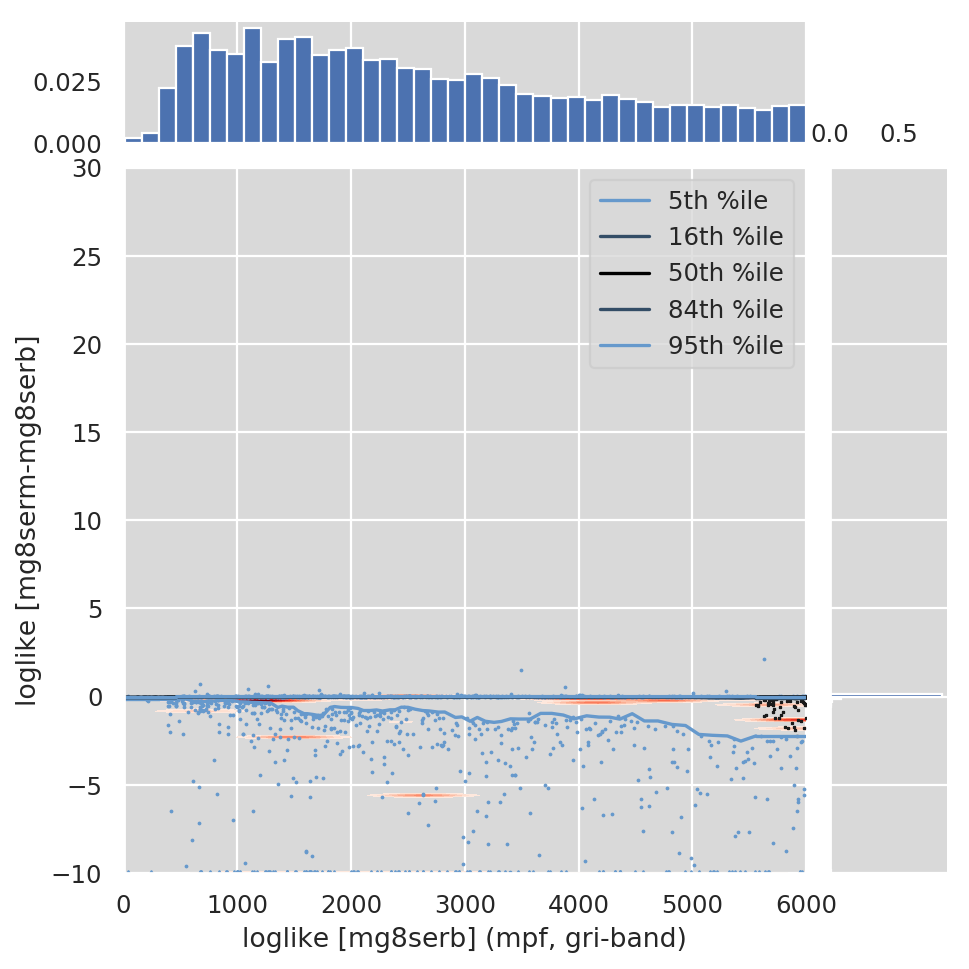

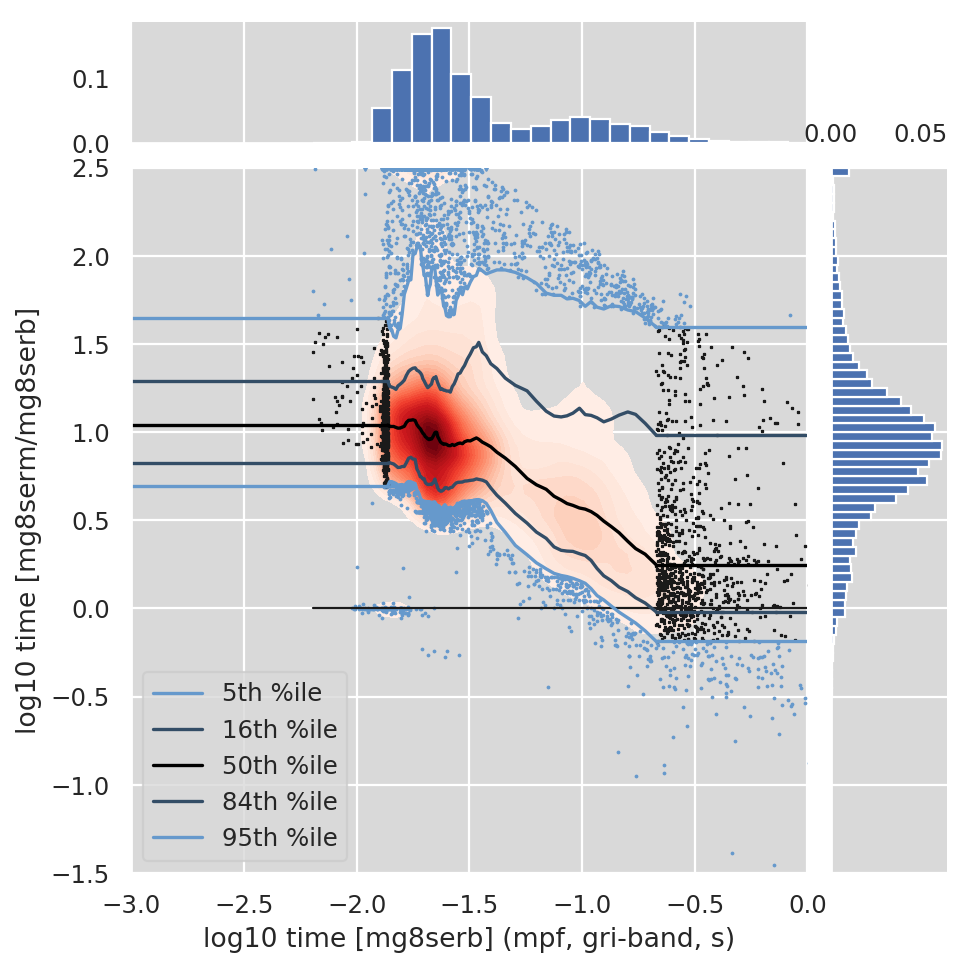

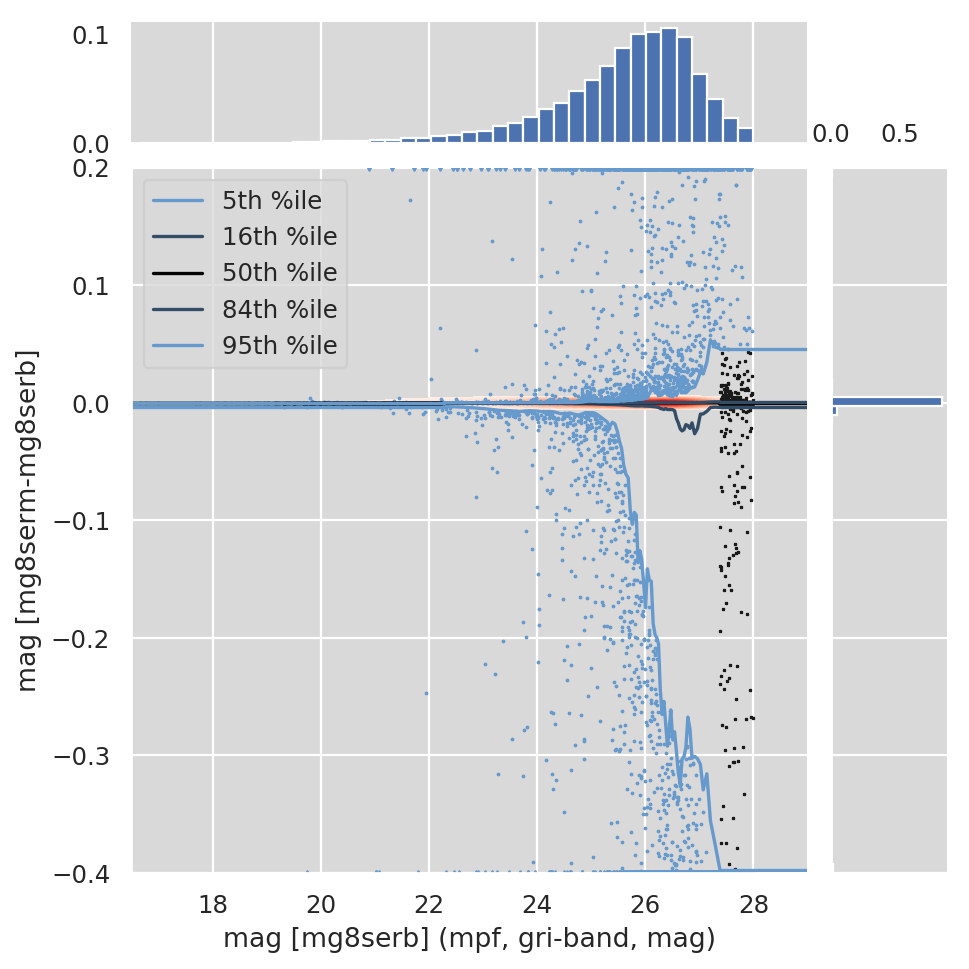

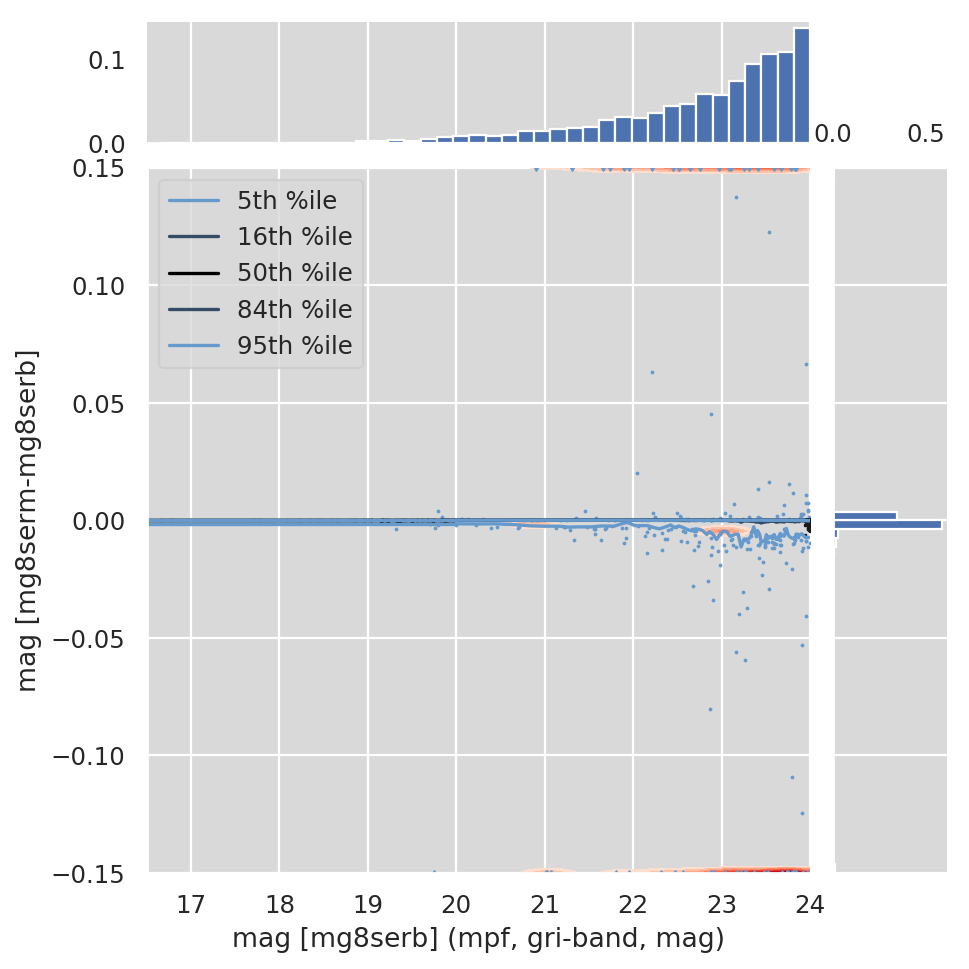

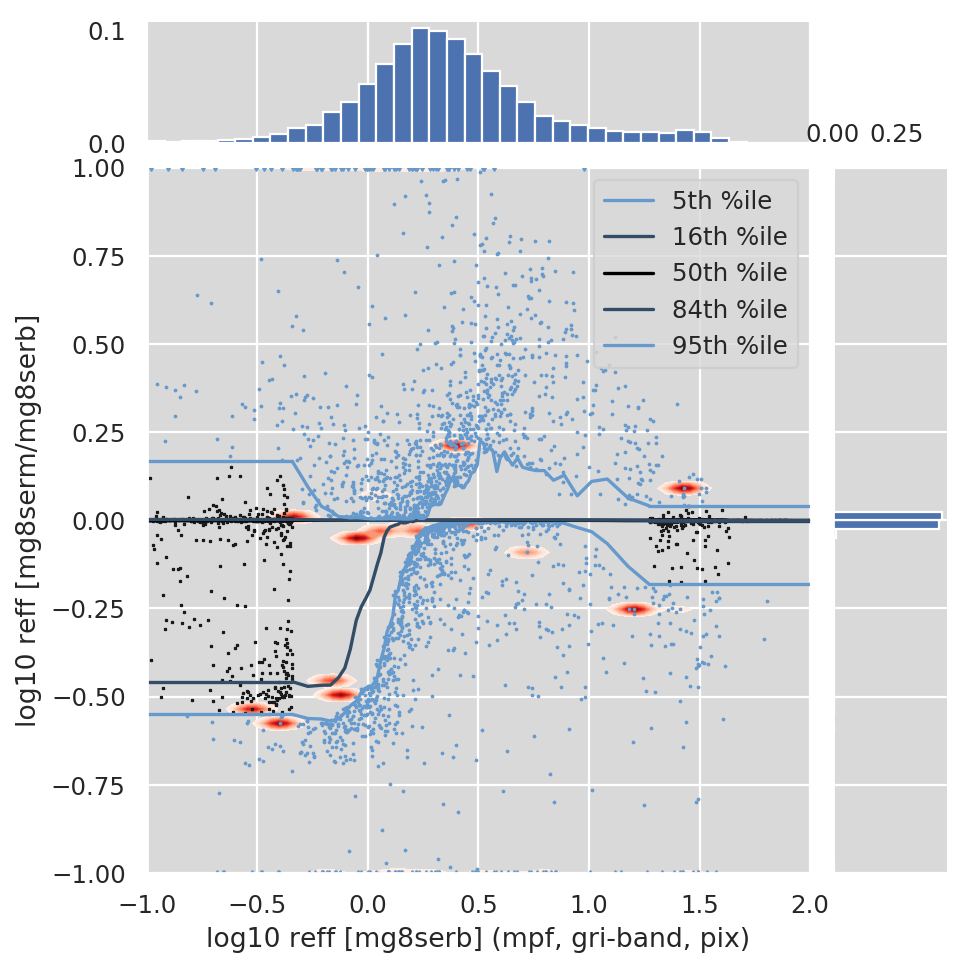

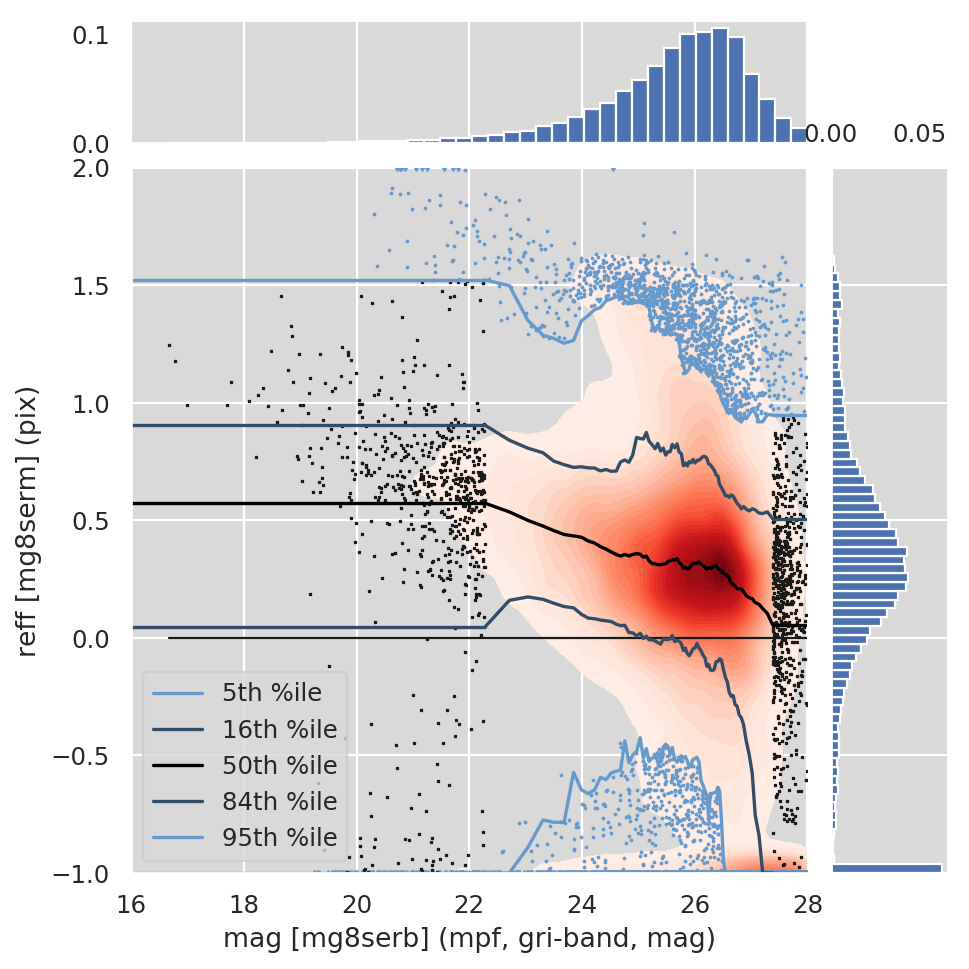

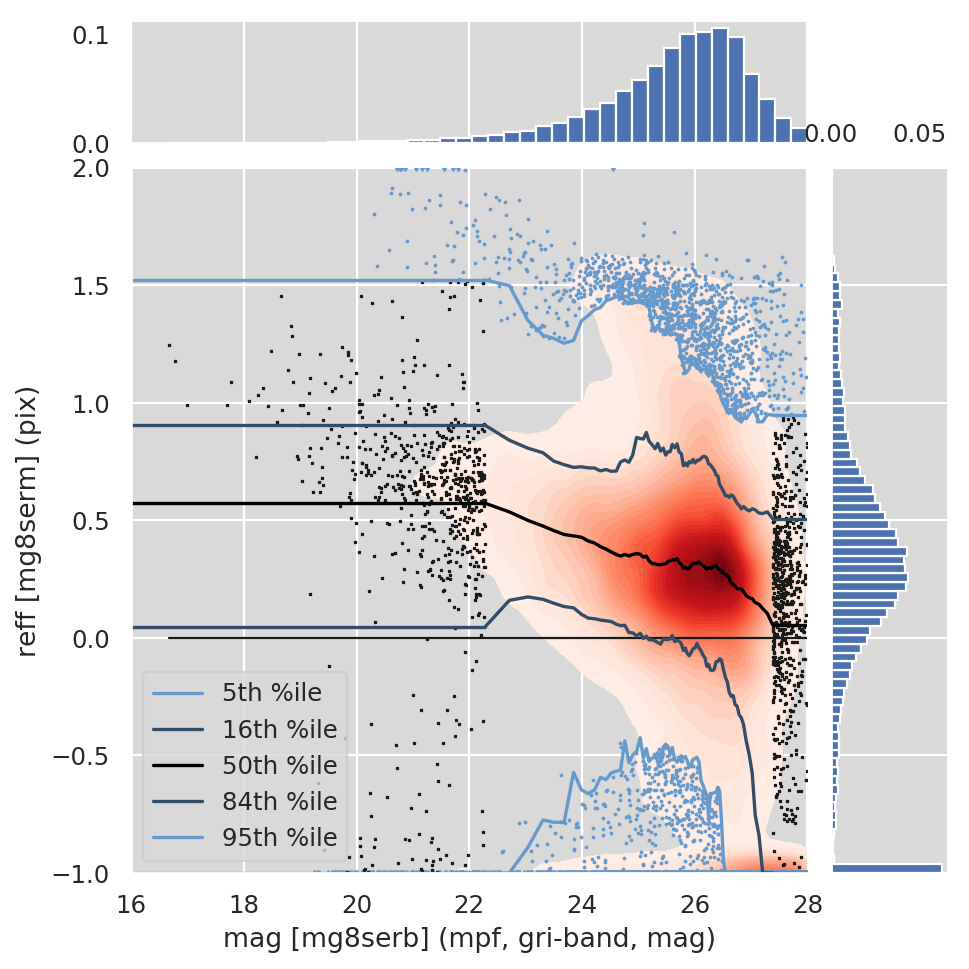

In [12]:
columns_plot["time"] = dict(postfix="", log=True, ratio=True, limx=(-2.3, 0.7), limy=(-1., 3.))
plot_models_algo(data, "gri", "mpf", ("mg8serb", "mg8serm"), columns_plot, columns_plot_size_algo)